# Fantasy Football Draft Analysis

Author: Melody Bass

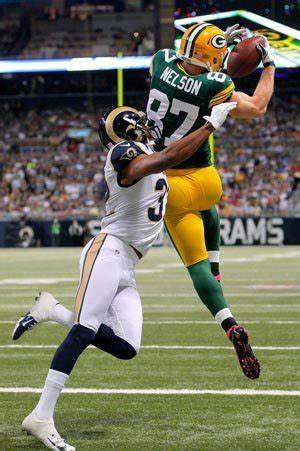

## Overview

## Business Problem

## Data Understanding

In [285]:
# Basics
import pandas as pd
import numpy as np
import itertools

# Visualization
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import matplotlib.patches as mpatches
from matplotlib.pylab import rcParams
import time

# Modeling
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import acf, pacf, adfuller
from sklearn.linear_model import LassoLarsCV
from fbprophet import Prophet as proph

# Warnings
import warnings
from statsmodels.tools.sm_exceptions import ConvergenceWarning
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.filterwarnings('ignore')

In [205]:
# load in player fantasy stats data as player_df
player_df = pd.read_csv('data/league_data/player_data/Yahoo-406.l.12345-Players.csv')
player_df.head()

,ID,OR,Last Name,First Name,Team,Status,Status Details,Eligible Positions,Avg. Pick,Avg. Round,Avg. Cost,% Drafted,Pass Yds (O),Pass TD (O),Int (O),Rush Att (O),Rush Yds (O),Rush TD (O),Targets (O),Rec (O),Rec Yds (O),Rec TD (O),Ret TD (O),2-PT (O),Fum Lost (O),Fum Ret TD (O),FG 0-19 (K),FG 20-29 (K),FG 30-39 (K),FG 40-49 (K),FG 50+ (K),PAT Made (K),Pts Allow (DT),Sack (DT),Int (DT),Fum Rec (DT),TD (DT),Safe (DT),Blk Kick (DT),Ret TD (DT),XPR (DT),Pts Allow 0 (DT),Pts Allow 1-6 (DT),Pts Allow 7-13 (DT),Pts Allow 14-20 (DT),Pts Allow 21-27 (DT),Pts Allow 28-34 (DT),Pts Allow 35+ (DT),Image
0,406.p.30977,1,Allen,Josh,Buf,Available,NaN,QB,29.7,3.6,$22.8,100%,4407.0,36.0,15.0,122.0,763.0,6.0,0.0,0.0,0.0,0.0,0.0,3.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/JqjwXUxHWb2L...
1,406.p.32676,2,Herbert,Justin,LAC,Available,NaN,QB,61.1,6.8,$5.8,100%,5014.0,38.0,15.0,63.0,302.0,3.0,0.0,0.0,0.0,0.0,0.0,6.0,1.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/j0W7BC4RRiJB...
2,406.p.5228,3,Brady,Tom,TB,Available,NaN,QB,63.5,7.0,$4.6,100%,5316.0,43.0,12.0,28.0,81.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/Z71ic_5aqQfG...
3,406.p.30123,4,Mahomes,Patrick,KC,Available,NaN,QB,16.6,2.2,$35.3,100%,4839.0,37.0,13.0,66.0,381.0,2.0,0.0,0.0,0.0,0.0,0.0,2.0,4.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/oMIJokh4hdPk...
4,406.p.30182,5,Kupp,Cooper,LAR,Available,NaN,WR,42.0,4.8,$13.3,100%,0.0,0.0,0.0,4.0,18.0,0.0,191.0,145.0,1947.0,16.0,0.0,1.0,0.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,https://s.yimg.com/iu/api/res/1.2/hYxm3SR9yMjD...


In [206]:
# load in player fantasy points time series

wr_ts = pd.read_csv('data/wr_ts.csv')
wr_ts = wr_ts.drop('Unnamed: 0', axis=1).fillna(0)

qb_ts = pd.read_csv('data/qb_ts.csv')
qb_ts = qb_ts.drop('Unnamed: 0', axis=1).fillna(0)

rb_ts = pd.read_csv('data/rb_ts.csv')
rb_ts = rb_ts.drop('Unnamed: 0', axis=1).fillna(0)

te_ts = pd.read_csv('data/te_ts.csv')
te_ts = te_ts.drop('Unnamed: 0', axis=1).fillna(0)
qb_ts.tail(20)

,Aaron Rodgers,Baker Mayfield,Dak Prescott,Derek Carr,Deshaun Watson,Jameis Winston,Josh Allen,Kirk Cousins,Kyler Murray,Lamar Jackson,Matt Ryan,Matthew Stafford,Patrick Mahomes II,Russell Wilson,Ryan Tannehill,Tom Brady
65,18.3,21.0,0.0,2.1,23.4,0.0,37.7,20.3,34.1,30.2,27.8,15.3,25.9,13.0,37.0,23.4
66,26.1,8.0,0.0,23.2,26.8,0.0,32.3,23.6,16.4,21.3,19.9,0.7,20.2,19.9,18.3,29.9
67,26.0,16.2,0.0,22.9,26.8,-0.1,20.3,34.3,3.8,25.2,22.7,23.6,0.0,18.1,28.4,31.3
68,3.3,13.6,28.4,25.0,0.0,29.6,17.2,22.0,34.6,18.0,7.4,24.3,33.3,27.1,15.2,29.2
69,26.8,18.5,8.5,24.2,0.0,10.3,17.7,25.3,35.1,34.3,19.3,18.2,25.0,23.3,14.6,29.6
70,19.0,16.9,20.1,22.2,0.0,13.5,37.2,25.1,19.5,20.3,15.6,29.5,24.9,16.6,23.5,28.7
71,24.1,9.3,27.0,15.4,0.0,13.0,21.0,11.1,22.6,19.4,29.0,20.3,32.3,22.6,18.8,11.1
72,20.8,23.0,21.7,8.2,0.0,26.8,36.5,14.4,13.7,41.9,21.6,17.5,21.0,10.1,14.0,37.7
73,23.7,13.2,27.8,21.5,0.0,0.0,29.7,28.5,25.8,13.8,0.0,26.2,25.0,0.0,13.9,19.0
74,24.7,0.0,0.0,20.0,0.0,16.9,0.0,0.0,22.4,23.1,18.4,27.2,8.7,0.0,20.4,24.4


In [207]:
pd.set_option('max_columns', 100)
rb_ts.describe()

,Aaron Jones,Alvin Kamara,Austin Ekeler,Chase Edmonds,Christian McCaffrey,Cordarrelle Patterson,Dalvin Cook,Darrell Henderson Jr.,David Montgomery,Derrick Henry,Devin Singletary,Ezekiel Elliott,J.D. McKissic,Jamaal Williams,James Conner,Joe Mixon,Josh Jacobs,Kareem Hunt,Leonard Fournette,Mark Ingram II,Marlon Mack,Melvin Gordon III,Miles Sanders,Nick Chubb,Nyheim Hines,Ronald Jones II,Saquon Barkley,Tony Pollard
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,12.401176,18.288235,12.667059,5.437647,15.431765,2.734118,12.331765,3.718824,7.309412,13.518824,5.460000,15.616471,5.896471,7.568235,10.071765,11.903529,7.370588,11.296471,11.836471,9.625882,5.475294,13.404706,5.956471,10.162353,6.905882,5.323529,9.207059,4.383529
std,11.501910,12.394617,10.415743,7.355205,13.674256,6.896610,11.667060,6.558192,9.107671,12.393071,6.701443,9.670215,6.745765,7.653154,11.176747,9.901845,8.965540,10.676180,10.041163,9.098497,7.598808,9.781103,8.145046,10.367371,6.767330,6.797122,11.591097,6.568483
min,-0.200000,0.000000,0.000000,-0.100000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-0.600000,0.000000,-2.000000
25%,2.200000,8.400000,2.400000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,4.100000,0.000000,8.300000,0.000000,1.000000,0.000000,5.200000,0.000000,0.000000,0.000000,2.000000,0.000000,6.300000,0.000000,0.000000,1.100000,0.000000,0.000000,0.000000
50%,10.900000,17.800000,11.900000,1.700000,14.000000,0.000000,13.400000,0.000000,1.900000,10.700000,2.300000,16.500000,4.400000,5.800000,6.800000,10.300000,0.000000,9.800000,11.600000,8.200000,1.400000,12.100000,0.000000,8.900000,5.700000,1.200000,0.900000,0.500000
75%,18.300000,25.300000,20.200000,8.800000,26.100000,0.000000,20.400000,4.900000,11.900000,19.400000,10.200000,20.500000,8.600000,11.200000,15.400000,17.400000,13.400000,16.600000,17.600000,14.500000,9.200000,20.800000,10.000000,17.100000,10.400000,9.700000,17.900000,6.800000
max,49.200000,56.200000,41.500000,35.000000,47.700000,34.600000,48.600000,24.700000,29.200000,47.800000,23.000000,40.900000,25.700000,30.800000,40.300000,42.100000,35.900000,45.600000,44.100000,35.500000,31.900000,36.000000,35.200000,39.300000,28.500000,26.100000,43.900000,31.200000


In [208]:
# load in player fantasy stats data as player_df
qb_snap_ts = pd.read_csv('data/qb_snap_ts.csv')
qb_snap_ts = qb_snap_ts.drop('Unnamed: 0', axis=1).fillna(0)

rb_snap_ts = pd.read_csv('data/rb_snap_ts.csv')
rb_snap_ts = rb_snap_ts.drop('Unnamed: 0', axis=1).fillna(0)

wr_snap_ts = pd.read_csv('data/wr_snap_ts.csv')
wr_snap_ts = wr_snap_ts.drop('Unnamed: 0', axis=1).fillna(0)

te_snap_ts = pd.read_csv('data/te_snap_ts.csv')
te_snap_ts = te_snap_ts.drop('Unnamed: 0', axis=1).fillna(0)

wr_snap_ts.head()

,snaps_A.J. Brown,snaps_Adam Thielen,snaps_Allen Robinson II,snaps_Amari Cooper,snaps_Brandin Cooks,snaps_Chris Godwin,snaps_Christian Kirk,snaps_Cooper Kupp,snaps_Courtland Sutton,snaps_DJ Chark Jr.,snaps_DJ Moore,snaps_DK Metcalf,snaps_Davante Adams,snaps_DeAndre Hopkins,snaps_DeVante Parker,snaps_Diontae Johnson,snaps_Hunter Renfrow,snaps_Jakobi Meyers,snaps_Jarvis Landry,snaps_JuJu Smith-Schuster,snaps_Julio Jones,snaps_Keenan Allen,snaps_Kenny Golladay,snaps_Marquez Valdes-Scantling,snaps_Marquise Brown,snaps_Marvin Jones Jr.,snaps_Mecole Hardman,snaps_Michael Gallup,snaps_Michael Thomas,snaps_Mike Evans,snaps_Mike Williams,snaps_Robbie Anderson,snaps_Robert Woods,snaps_Russell Gage,snaps_Sammy Watkins,snaps_Stefon Diggs,snaps_Terry McLaurin,snaps_Tyler Boyd,snaps_Tyler Lockett,snaps_Tyreek Hill
0,0.0,65.0,3.0,61.0,67.0,0.0,0.0,39.0,0.0,0.0,0.0,0.0,67.0,79.0,0.0,0.0,0.0,0.0,0.0,25.0,48.0,52.0,44.0,0.0,0.0,68.0,0.0,0.0,58.0,0.0,0.0,57.0,43.0,0.0,38.0,58.0,0.0,42.0,26.0,50.0
1,0.0,62.0,0.0,48.0,65.0,29.0,0.0,30.0,0.0,0.0,0.0,0.0,71.0,67.0,63.0,0.0,0.0,0.0,62.0,39.0,48.0,50.0,33.0,0.0,0.0,56.0,0.0,0.0,58.0,55.0,0.0,43.0,45.0,0.0,45.0,60.0,0.0,0.0,61.0,47.0
2,0.0,63.0,0.0,44.0,57.0,11.0,0.0,38.0,0.0,0.0,0.0,0.0,67.0,71.0,58.0,0.0,0.0,0.0,60.0,51.0,58.0,61.0,45.0,0.0,0.0,68.0,0.0,0.0,46.0,47.0,0.0,49.0,60.0,0.0,42.0,52.0,0.0,30.0,66.0,39.0
3,0.0,55.0,0.0,53.0,64.0,9.0,0.0,49.0,0.0,0.0,0.0,0.0,40.0,78.0,47.0,0.0,0.0,0.0,46.0,54.0,16.0,49.0,0.0,0.0,0.0,64.0,0.0,0.0,69.0,59.0,0.0,55.0,59.0,0.0,60.0,48.0,0.0,39.0,50.0,58.0
4,0.0,68.0,0.0,55.0,72.0,17.0,0.0,63.0,0.0,0.0,0.0,0.0,56.0,64.0,3.0,0.0,0.0,0.0,49.0,66.0,0.0,71.0,0.0,0.0,0.0,58.0,0.0,0.0,0.0,68.0,0.0,39.0,64.0,0.0,59.0,49.0,0.0,5.0,38.0,46.0


## EDA

### Seasonality EDA

### Discussion on EDA

## SARIMAX Modeling

### Create Individual Time Series

In [210]:
def ts_lists(ts, exog_ts):
    player_list = []
    for col in ts.columns:
        player = ts[col].squeeze()
        player_list.append(player)
     
    player_list_names = []
    for col in ts.columns:
        player = col
        player_list_names.append(player)
    
    player_list_snaps = []
    for col in exog_ts.columns:
        player = exog_ts[col].squeeze()
        player_list_snaps.append(player)  
    return player_list, player_list_names, player_list_snaps    

In [211]:
qb_list, qb_list_names, qb_list_snaps = ts_lists(qb_ts, qb_snap_ts)
qb_list_names

['Aaron Rodgers',
 'Baker Mayfield',
 'Dak Prescott',
 'Derek Carr',
 'Deshaun Watson',
 'Jameis Winston',
 'Josh Allen',
 'Kirk Cousins',
 'Kyler Murray',
 'Lamar Jackson',
 'Matt Ryan',
 'Matthew Stafford',
 'Patrick Mahomes II',
 'Russell Wilson',
 'Ryan Tannehill',
 'Tom Brady']

In [212]:
wr_list, wr_list_names, wr_list_snaps = ts_lists(wr_ts, wr_snap_ts)
rb_list, rb_list_names, rb_list_snaps = ts_lists(rb_ts, rb_snap_ts)
te_list, te_list_names, te_list_snaps = ts_lists(te_ts, te_snap_ts)
te_list_names

['Dallas Goedert',
 'Dalton Schultz',
 'Darren Waller',
 'David Njoku',
 'Evan Engram',
 'George Kittle',
 'Gerald Everett',
 'Hunter Henry',
 'Irv Smith Jr.',
 'Mark Andrews',
 'Mike Gesicki',
 'Noah Fant',
 'Robert Tonyan',
 'T.J. Hockenson',
 'Travis Kelce',
 'Tyler Higbee',
 'Zach Ertz']

### Seasonal Decompostion

In [118]:
def decomposition_plot(ts):
    decomposition = sm.tsa.seasonal_decompose(ts, model='additive', period=16)

    #Gather the trend, seasonality, and residuals
    trend = decomposition.trend
    seasonal = decomposition.seasonal
    residual = decomposition.resid

    # Plot gathered statistics
    plt.figure(figsize=(12,8))
    plt.subplot(411)
    plt.plot(ts, label='Original', color='blue')
    plt.legend(loc='best')
    plt.subplot(412)
    plt.plot(trend, label='Trend', color='blue')
    plt.legend(loc='best')
    plt.subplot(413)
    plt.plot(seasonal,label='Seasonality', color='blue')
    plt.legend(loc='best')
    plt.subplot(414)
    plt.plot(residual, label='Residuals', color='blue')
    plt.legend(loc='best')
    plt.tight_layout();
    return decomposition_plot

<function __main__.decomposition_plot(ts)>

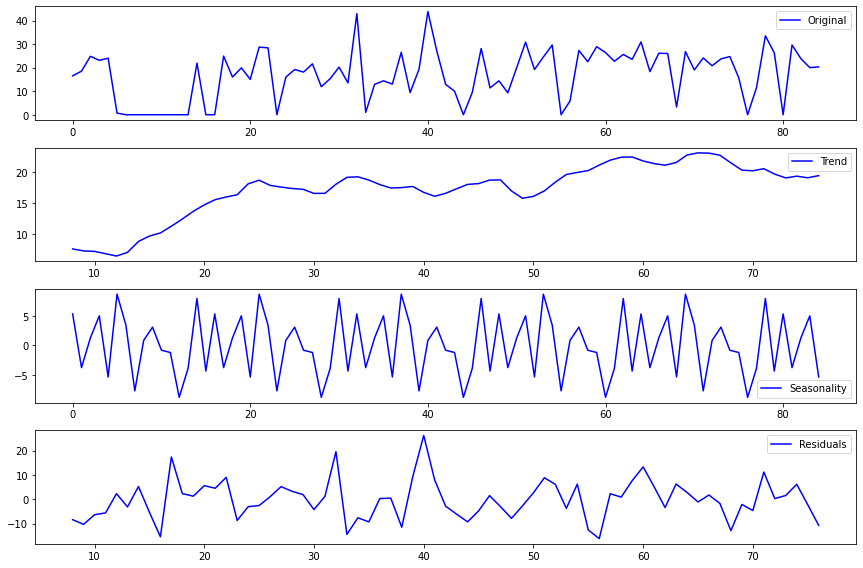

In [119]:
#Decomposition plot of the Arena District
decomposition_plot(qb_list[0])

In [120]:
qb_ts.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 85 entries, 0 to 84
Data columns (total 16 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Aaron Rodgers       85 non-null     float64
 1   Baker Mayfield      85 non-null     float64
 2   Dak Prescott        85 non-null     float64
 3   Derek Carr          85 non-null     float64
 4   Deshaun Watson      85 non-null     float64
 5   Jameis Winston      85 non-null     float64
 6   Josh Allen          85 non-null     float64
 7   Kirk Cousins        85 non-null     float64
 8   Kyler Murray        85 non-null     float64
 9   Lamar Jackson       85 non-null     float64
 10  Matt Ryan           85 non-null     float64
 11  Matthew Stafford    85 non-null     float64
 12  Patrick Mahomes II  85 non-null     float64
 13  Russell Wilson      85 non-null     float64
 14  Ryan Tannehill      85 non-null     float64
 15  Tom Brady           85 non-null     float64
dtypes: float64

### Stationarity Check

In [121]:
def stationarity_check(TS):
    
    # Calculate rolling statistics
    roll_mean = TS.rolling(window=8, center=False).mean()
    roll_std = TS.rolling(window=8, center=False).std()
    
    # Perform the Dickey Fuller test
    dftest = adfuller(TS) 
    
    # Plot rolling statistics:
    fig = plt.figure(figsize=(12,6))
    orig = plt.plot(TS, color='blue',label='Original')
    mean = plt.plot(roll_mean, color='red', label='Rolling Mean')
    std = plt.plot(roll_std, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Print Dickey-Fuller test results
    print('Results of Dickey-Fuller Test: \n')

    dfoutput = pd.Series(dftest[0:4], index=['Test Statistic', 'p-value', 
                                             '#Lags Used', 'Number of Observations Used'])
    for key, value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)
    
    return None

In [122]:
# Get decomposition for stationarity check
decomposition = sm.tsa.seasonal_decompose(qb_list[0], model='additive', period=16)
residual = decomposition.resid
ts_log_decompose = residual
ts_log_decompose.dropna(inplace=True)

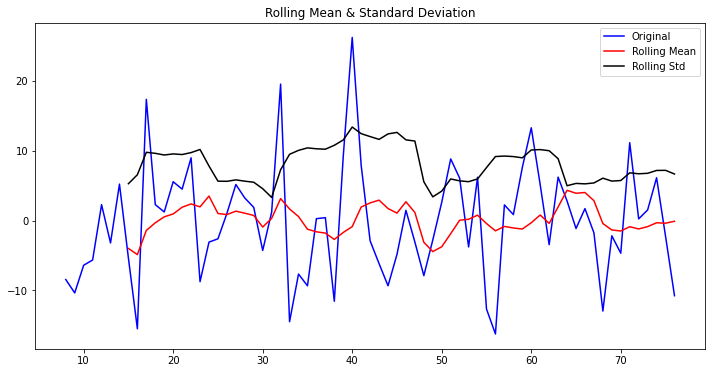

Results of Dickey-Fuller Test: 

Test Statistic                 -5.403261
p-value                         0.000003
#Lags Used                      5.000000
Number of Observations Used    63.000000
Critical Value (1%)            -3.538695
Critical Value (5%)            -2.908645
Critical Value (10%)           -2.591897
dtype: float64


In [123]:
stationarity_check(ts_log_decompose)

The p-value is <0.05, which means we accept the null hypothesis that the residuals are stationary. We can move on to check our autocorrelation and partial autocorrelation plots.

### Autocorrelation and Partial Autocorrelation

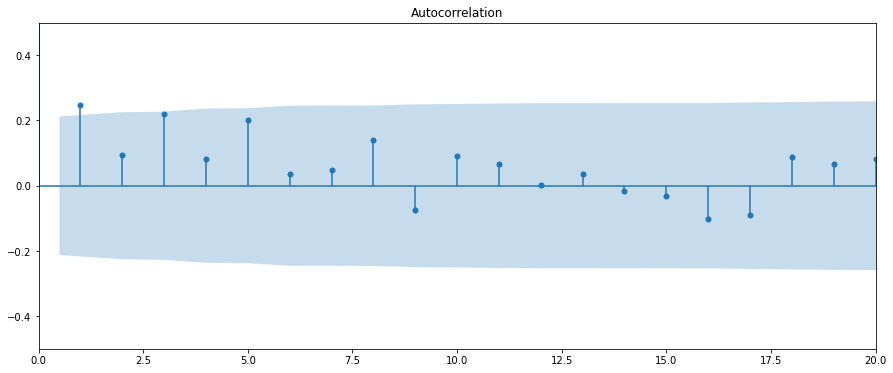

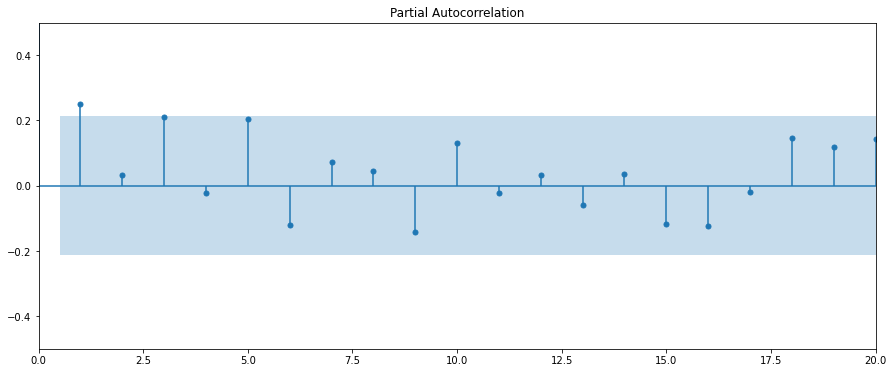

In [124]:
plot_acf(qb_list[0]); plt.xlim(0,20); plt.ylim(-0.5,0.5);plt.show()
plot_pacf(qb_list[0]); plt.xlim(0,20); plt.ylim(-0.5,0.5);plt.show()

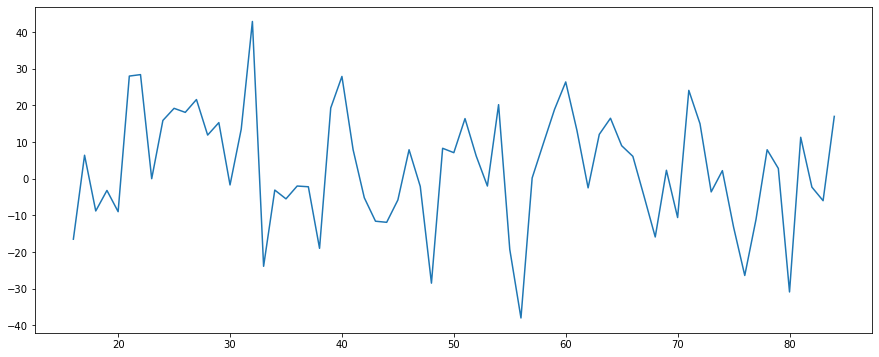

In [125]:
qb_list[0].diff(periods=16).plot();

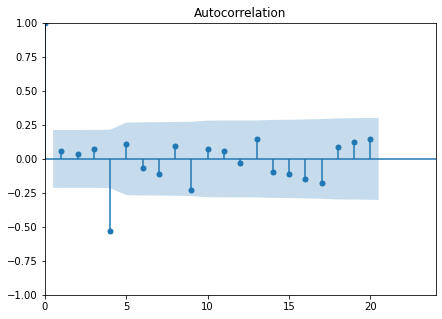

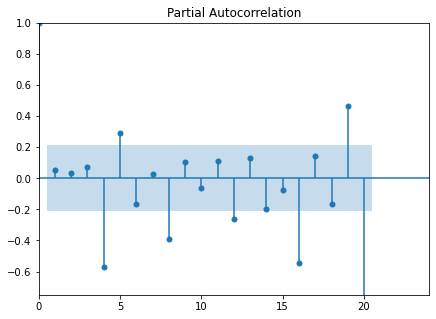

In [126]:
rcParams['figure.figsize']=7,5
plot_acf(qb_list[0].diff(periods=4).bfill()); plt.xlim(0,24); plt.show()
plot_pacf(qb_list[0].diff(periods=4).bfill()); plt.xlim(0,24); plt.ylim(-0.75,1);plt.show()

### Gridsearch for SARIMAX Model

Next, I am going to conduct gridsearch to find optimal values for (p,d,q) and (P,D,Q,s) ranked by lowest AIC. This will provide optimal parameters for each of my players for Sarimax modeling. 

In [127]:
def gridsearch(ts, player_name, player_snaps):

    # Define the p, d and q parameters to take any value between 0 and 2
    p = d = q = range(0, 2)

    # Generate all different combinations of p, q and q triplets
    pdq = list(itertools.product(p, d, q))

    # Generate all different combinations of seasonal p, q and q triplets
    pdqs = [(x[0], x[1], x[2], 0) for x in list(itertools.product(p, d, q))]
    
    # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
    ans = []
    for df, name, snaps in zip(ts, player_name, player_snaps):
            for comb in pdq:
                for combs in pdqs:
                    try:
                        mod = sm.tsa.statespace.SARIMAX(df,
                                                        exog=snaps,
                                                        order=comb,
                                                        seasonal_order=combs,
                                                        enforce_stationarity=False,
                                                        enforce_invertibility=False)

                        output = mod.fit()
                        ans.append([name, comb, combs, output.aic])
                    except:
                        continue
                        
    # Find the parameters with minimal AIC value
    ans_df = pd.DataFrame(ans, columns=['name', 'pdq', 'pdqs', 'aic'])            
    #Return the best set of parameters based on AIC
    best_para = ans_df.loc[ans_df.groupby("name")["aic"].idxmin()]
    return best_para

In [128]:
gridsearch(qb_list, qb_list_names, qb_list_snaps)

,name,pdq,pdqs,aic
3,Aaron Rodgers,"(0, 1, 1)","(0, 0, 0, 0)",564.916297
13,Baker Mayfield,"(1, 0, 1)","(0, 0, 0, 0)",510.911836
19,Dak Prescott,"(0, 1, 1)","(0, 0, 0, 0)",573.703541
27,Derek Carr,"(0, 1, 1)","(0, 0, 0, 0)",532.572588
35,Deshaun Watson,"(0, 1, 1)","(0, 0, 0, 0)",548.987697
41,Jameis Winston,"(0, 0, 1)","(0, 0, 0, 0)",523.348882
51,Josh Allen,"(0, 1, 1)","(0, 0, 0, 0)",557.924810
59,Kirk Cousins,"(0, 1, 1)","(0, 0, 0, 0)",533.511544
65,Kyler Murray,"(0, 0, 1)","(0, 0, 0, 0)",520.353682
75,Lamar Jackson,"(0, 1, 1)","(0, 0, 0, 0)",552.386860


In [129]:
gridsearch(wr_list, wr_list_names, wr_list_snaps)

,name,pdq,pdqs,aic
5,A.J. Brown,"(1, 0, 1)","(0, 0, 0, 0)",536.472787
9,Adam Thielen,"(0, 0, 1)","(0, 0, 0, 0)",569.221609
19,Allen Robinson II,"(0, 1, 1)","(0, 0, 0, 0)",538.630323
31,Amari Cooper,"(1, 1, 1)","(0, 0, 0, 0)",605.248293
35,Brandin Cooks,"(0, 1, 1)","(0, 0, 0, 0)",571.388858
45,Chris Godwin,"(1, 0, 1)","(0, 0, 0, 0)",570.450856
51,Christian Kirk,"(0, 1, 1)","(0, 0, 0, 0)",541.795791
59,Cooper Kupp,"(0, 1, 1)","(0, 0, 0, 0)",584.921079
67,Courtland Sutton,"(0, 1, 1)","(0, 0, 0, 0)",513.305202
75,DJ Chark Jr.,"(0, 1, 1)","(0, 0, 0, 0)",530.627928


In [130]:
gridsearch(rb_list, rb_list_names, rb_list_snaps)

,name,pdq,pdqs,aic
7,Aaron Jones,"(1, 1, 1)","(0, 0, 0, 0)",599.557419
11,Alvin Kamara,"(0, 1, 1)","(0, 0, 0, 0)",623.373227
19,Austin Ekeler,"(0, 1, 1)","(0, 0, 0, 0)",549.734524
27,Chase Edmonds,"(0, 1, 1)","(0, 0, 0, 0)",479.267484
35,Christian McCaffrey,"(0, 1, 1)","(0, 0, 0, 0)",568.037718
43,Cordarrelle Patterson,"(0, 1, 1)","(0, 0, 0, 0)",505.577226
51,Dalvin Cook,"(0, 1, 1)","(0, 0, 0, 0)",563.485656
57,Darrell Henderson Jr.,"(0, 0, 1)","(0, 0, 0, 0)",442.285814
67,David Montgomery,"(0, 1, 1)","(0, 0, 0, 0)",512.767750
75,Derrick Henry,"(0, 1, 1)","(0, 0, 0, 0)",613.141746


In [131]:
gridsearch(te_list, te_list_names, te_list_snaps)

,name,pdq,pdqs,aic
1,Dallas Goedert,"(0, 0, 1)","(0, 0, 0, 0)",491.422922
9,Dalton Schultz,"(0, 0, 1)","(0, 0, 0, 0)",483.282841
21,Darren Waller,"(1, 0, 1)","(0, 0, 0, 0)",508.536732
29,David Njoku,"(1, 0, 1)","(0, 0, 0, 0)",493.494657
35,Evan Engram,"(0, 1, 1)","(0, 0, 0, 0)",510.240696
45,George Kittle,"(1, 0, 1)","(0, 0, 0, 0)",570.094026
51,Gerald Everett,"(0, 1, 1)","(0, 0, 0, 0)",486.485191
59,Hunter Henry,"(0, 1, 1)","(0, 0, 0, 0)",497.741479
65,Irv Smith Jr.,"(0, 0, 1)","(0, 0, 0, 0)",431.055872
79,Mark Andrews,"(1, 1, 1)","(0, 0, 0, 0)",557.247354


### Best Parameters SARIMAX Model

Now that we have our optimal parameters for each zip code from our gridsearch, we will use the to build a sarimax model for each zip code.  Following are 3 functions we will use to build, evaluate and test each model, and forecast predictions for each of our top 10 zip codes.

#### Functions for Modeling

In [132]:
# Define function to build SARIMAX model, print summary and output diagnostic plots
def sarimax(ts, exog, order=(1, 1, 1), seasonal_order=(1, 1, 1, 17)):
    '''
    Input: 
    ts : Time series data.
    order : (p, d, q) values for ARIMA. Default = (1, 1, 1)
    seasonal_order : Seasonal (P, D, Q, s) values for SARIMA.
        Default = (1, 1, 1, 12).
        
    Output:
    Prints model output summary.
    Plots model diagnostics.
    
    Returns: Model output.
    '''
    
    # Sarimax model
    SARIMAX = sm.tsa.statespace.SARIMAX(ts,
                                        exog=exog,
                                        order=order, 
                                        seasonal_order=seasonal_order, 
                                        enforce_stationarity=False, 
                                        enforce_invertibility=False)
                                            
    # Fit the model and print results
    output = SARIMAX.fit()
    
    # Print output summary
    print(output.summary().tables[1])
    output.plot_diagnostics(figsize=(15,18));
    
    return output

In [133]:
def ose_forecast(ts, output, exog, player =''):
    '''
    Plot forecast with real and predicted data.
    
    Input:
        ts : Time series.
        output : SARIMAX model output. 
        neighborhood : Name of city for plot title. 
        
    Output:
        Prints RMSE.
        Plots real vs. model predicted plot.
    '''

    # Get predictions starting from 2019-06-30 and calculate confidence intervals
    
    pred = output.get_prediction(start=70, exog=exog, dynamic=False)
        
    # Get the real and predicted values
    ts_forecasted = pred.predicted_mean
    ts_truth = ts[70:].values
    
    # Calc RMSE
    mse = mean_squared_error(ts_truth, ts_forecasted)
    rmse = np.sqrt(mse)

    # Print RMSE
    print('The RMSE of our forecasts is {}'.format(round(rmse, 2)))

    # Confidence Intervals
    pred_conf = pred.conf_int()

    ### Plot real vs predicted w/ confidence intervals ###

    rcParams['figure.figsize'] = 15, 6

    # Plot observed values
    ax = ts[25:].plot(label='observed')

    # Plot predicted values
    
    ts_forecasted.plot(ax=ax, label='one-step ahead forecast', alpha=0.5)

    # Plot the range for confidence intervals
    ax.fill_between(pred_conf.index,
                    pred_conf.iloc[:, 0],
                    pred_conf.iloc[:, 1], color='g', alpha=.3)
        
    # Title
    ax.set_title(player)

    # Set axes labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Home Value (USD)')
    plt.legend()

    return plt.show()

In [134]:
qb_snap_ts.describe()

,snaps_Aaron Rodgers,snaps_Baker Mayfield,snaps_Dak Prescott,snaps_Derek Carr,snaps_Deshaun Watson,snaps_Jameis Winston,snaps_Josh Allen,snaps_Kirk Cousins,snaps_Kyler Murray,snaps_Lamar Jackson,snaps_Matt Ryan,snaps_Matthew Stafford,snaps_Patrick Mahomes II,snaps_Russell Wilson,snaps_Ryan Tannehill,snaps_Tom Brady
count,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000,85.000000
mean,52.388235,45.411765,54.647059,59.011765,41.564706,35.658824,45.011765,60.541176,34.988235,38.611765,61.447059,53.647059,47.423529,59.000000,39.635294,64.176471
std,27.355288,30.727797,28.663776,19.816115,32.393947,33.503572,31.148070,20.237608,34.228050,33.116711,19.236935,24.896790,31.651892,21.067352,31.634011,18.135847
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,50.000000,0.000000,55.000000,56.000000,0.000000,0.000000,0.000000,57.000000,0.000000,0.000000,59.000000,56.000000,0.000000,57.000000,0.000000,61.000000
50%,62.000000,60.000000,66.000000,63.000000,59.000000,35.000000,61.000000,65.000000,46.000000,54.000000,66.000000,61.000000,61.000000,63.000000,55.000000,68.000000
75%,70.000000,69.000000,71.000000,68.000000,66.000000,67.000000,68.000000,71.000000,67.000000,68.000000,71.000000,68.000000,70.000000,70.000000,64.000000,74.000000
max,90.000000,83.000000,99.000000,92.000000,89.000000,95.000000,87.000000,91.000000,88.000000,98.000000,91.000000,84.000000,98.000000,84.000000,100.000000,87.000000


In [135]:
# Forecast 5 year predictions - Home Sale Values #

def dynamic_forecast(ts, model_output, exog, steps, player='', save_fig=False):
    '''
    Plots dynamic forecast for specified time into the future.
    
    Inputs: 
        ts : Time series data.
        model_output : Output results from our model.
        years : n-years to forcast into the future.
        neighborhood: Name of neighborhood for plots
            
    Outputs:
        Prints : Time series plot with one step ahead forecast.
        Returns : Dictionary of predictions.
    
    '''
    
    # Get forecast and confidence interval for steps ahead in future
    future = model_output.get_forecast(steps=steps, exog=exog, dynamic=True)
    future_conf = future.conf_int()
    
    ### Plot forecast ###
    
    # Observed
    ax = ts.plot(label='Observed', figsize=(12, 6))
    # Predicted
    future.predicted_mean.plot(ax=ax, label='dynamic forecast', alpha=0.9)

    # Confidence Intervals
    ax.fill_between(future_conf.index,
                    future_conf.iloc[:, 0],
                    future_conf.iloc[:, 1], color='k', alpha=.25)
    
    # Title
    ax.set_title(f"1 Year Forecast for {player}")
    
    # x & y-labels
    ax.set_xlabel('Date')
    ax.set_ylabel('Median Home Sale Value (USD)')
    
    # Legend
    ax.legend()
    
    if save_fig:
        plt.savefig(f'./images/dynamic_forecast_{player}.jpeg')
    
    # Print plot
    plt.show()

    # Forecast prediction for n-years into the future
    forecast = future.predicted_mean
    maximum = future_conf.iloc[-1,1]
    minimum = future_conf.iloc[-1,0]
    
    # Create dictionary of predictions
    predictions = {}
    predictions['forecast'] = forecast.round()
    predictions['minimum'] = minimum.round()
    predictions['maximum'] = maximum.round()
    
    return predictions

#### Aaron Rodgers

                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
snaps_Aaron Rodgers     0.3009      0.037      8.070      0.000       0.228       0.374
ma.L1                  -0.9681      0.053    -18.318      0.000      -1.072      -0.865
sigma2                 52.0669      6.946      7.496      0.000      38.453      65.680


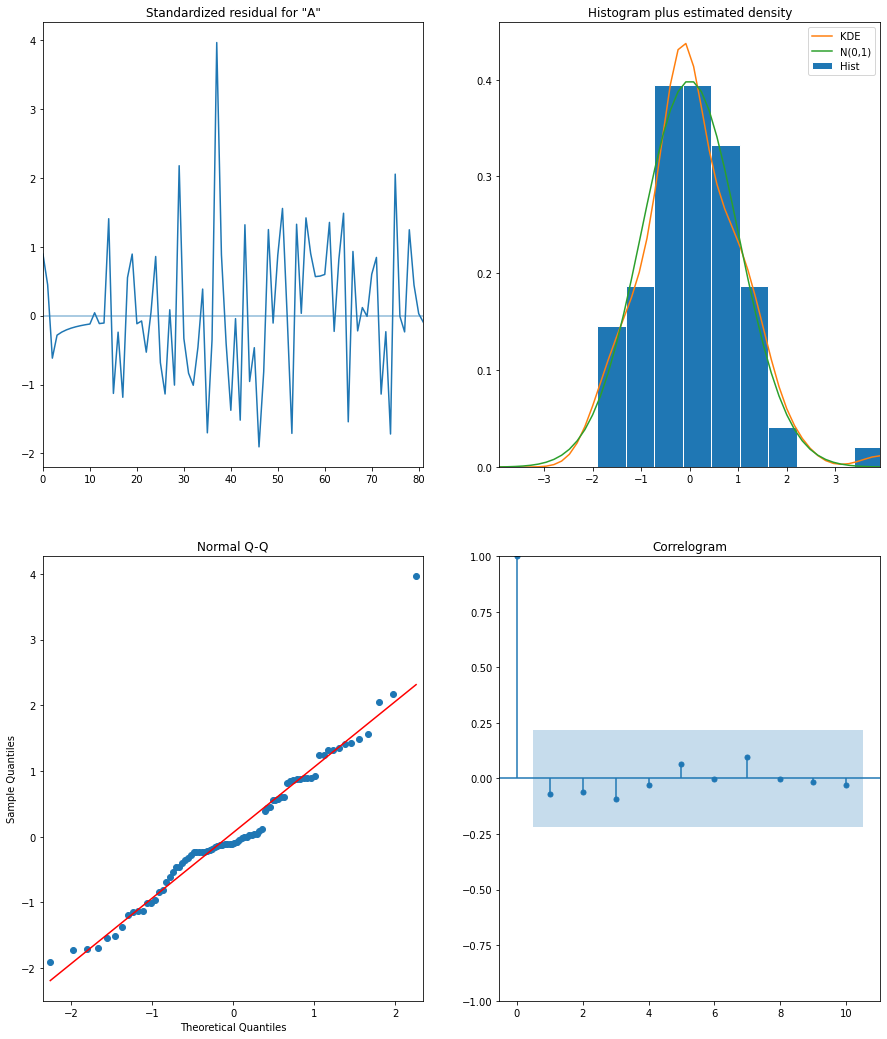

In [136]:
 AR_output = sarimax(qb_list[0], qb_list_snaps[0], order=(0, 1, 1), seasonal_order=(0, 0, 0, 0))

The RMSE of our forecasts is 6.31


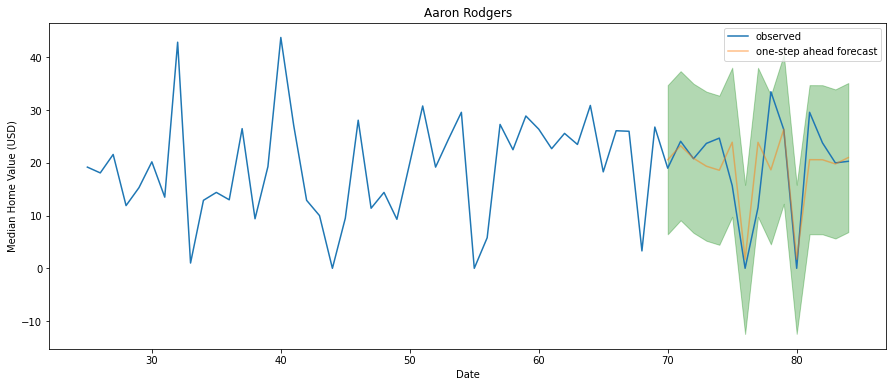

In [137]:
ose_forecast(qb_list[0], AR_output, qb_list_snaps[0][70:], player ='Aaron Rodgers')

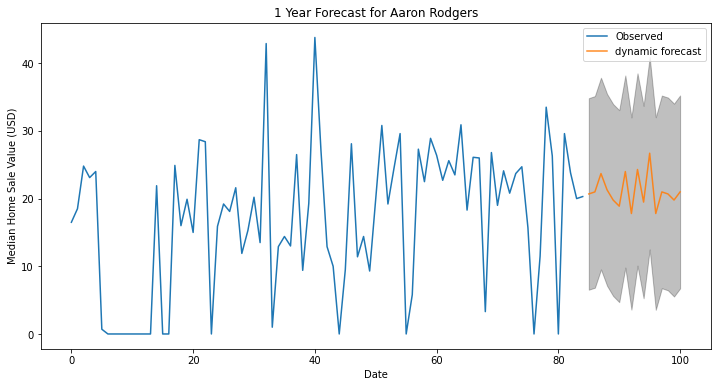

{'forecast': 85     21.0
 86     21.0
 87     24.0
 88     21.0
 89     20.0
 90     19.0
 91     24.0
 92     18.0
 93     24.0
 94     19.0
 95     27.0
 96     18.0
 97     21.0
 98     21.0
 99     20.0
 100    21.0
 Name: predicted_mean, dtype: float64,
 'minimum': 7.0,
 'maximum': 35.0}

In [138]:
dynamic_forecast(qb_list[0], AR_output, qb_list_snaps[0][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[0].mean()),
                 16, player='Aaron Rodgers', save_fig=False)


#### Dak Prescott

                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
snaps_Baker Mayfield     0.2422      0.008     28.671      0.000       0.226       0.259
ar.L1                   -0.0599      0.103     -0.583      0.560      -0.261       0.141
sigma2                  25.9889      3.092      8.405      0.000      19.929      32.049


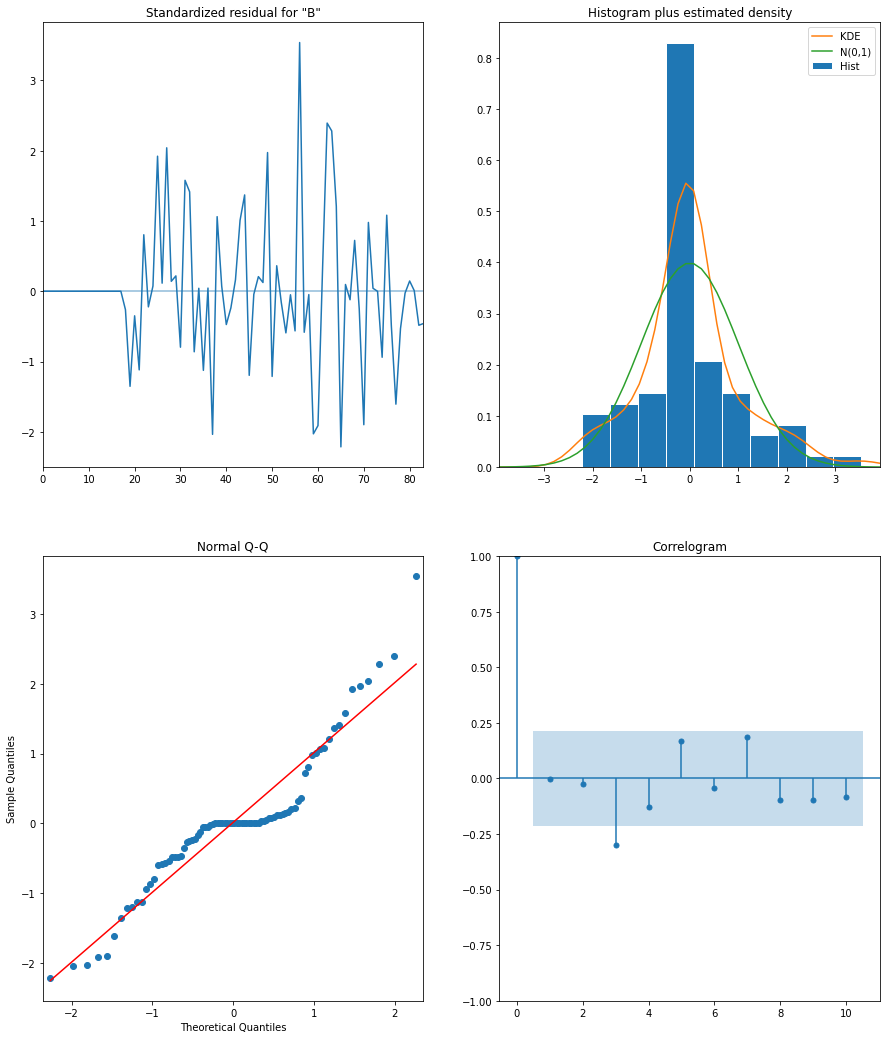

In [139]:
DP_output = sarimax(qb_list[1], qb_list_snaps[1], order=(1, 0, 0), seasonal_order=(0, 0, 0, 0))

The RMSE of our forecasts is 4.21


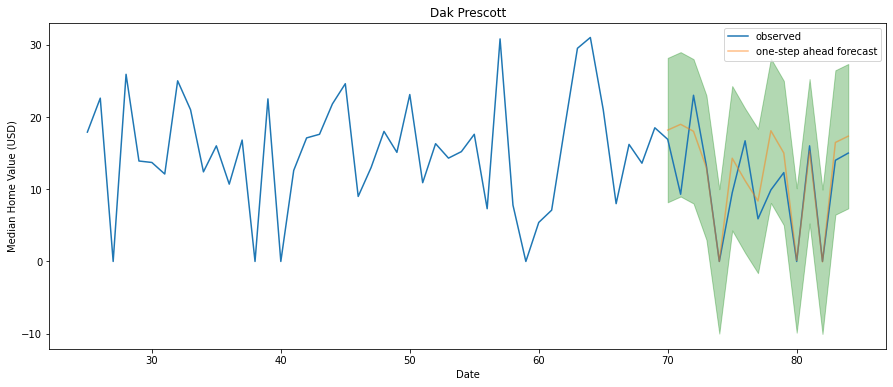

In [140]:
ose_forecast(qb_list[1], DP_output, qb_list_snaps[1][70:], player ='Dak Prescott')

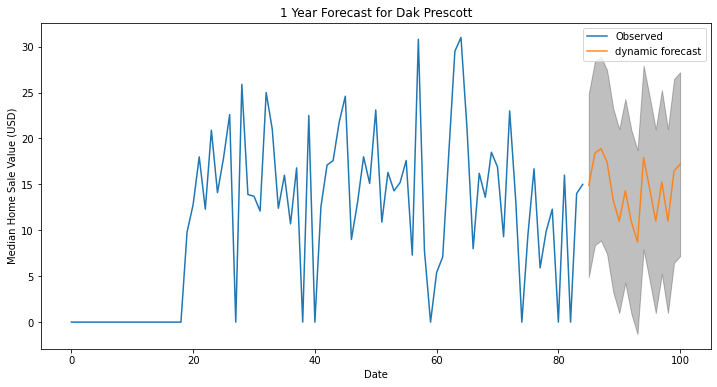

{'forecast': 85     15.0
 86     18.0
 87     19.0
 88     17.0
 89     13.0
 90     11.0
 91     14.0
 92     11.0
 93      9.0
 94     18.0
 95     15.0
 96     11.0
 97     15.0
 98     11.0
 99     16.0
 100    17.0
 Name: predicted_mean, dtype: float64,
 'minimum': 7.0,
 'maximum': 27.0}

In [141]:
dynamic_forecast(qb_list[1], DP_output, qb_list_snaps[1][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[1].mean()),
                 16, player='Dak Prescott', save_fig=False)


#### Jalen Hurts

                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
snaps_Dak Prescott     0.2899         -0       -inf      0.000       0.290       0.290
ma.L1                  0.0943         -0       -inf      0.000       0.094       0.094
ma.S.L17            7.917e+13    6.5e-33   1.22e+46      0.000    7.92e+13    7.92e+13
sigma2               4.17e-16   2.71e-10   1.54e-06      1.000   -5.31e-10    5.31e-10


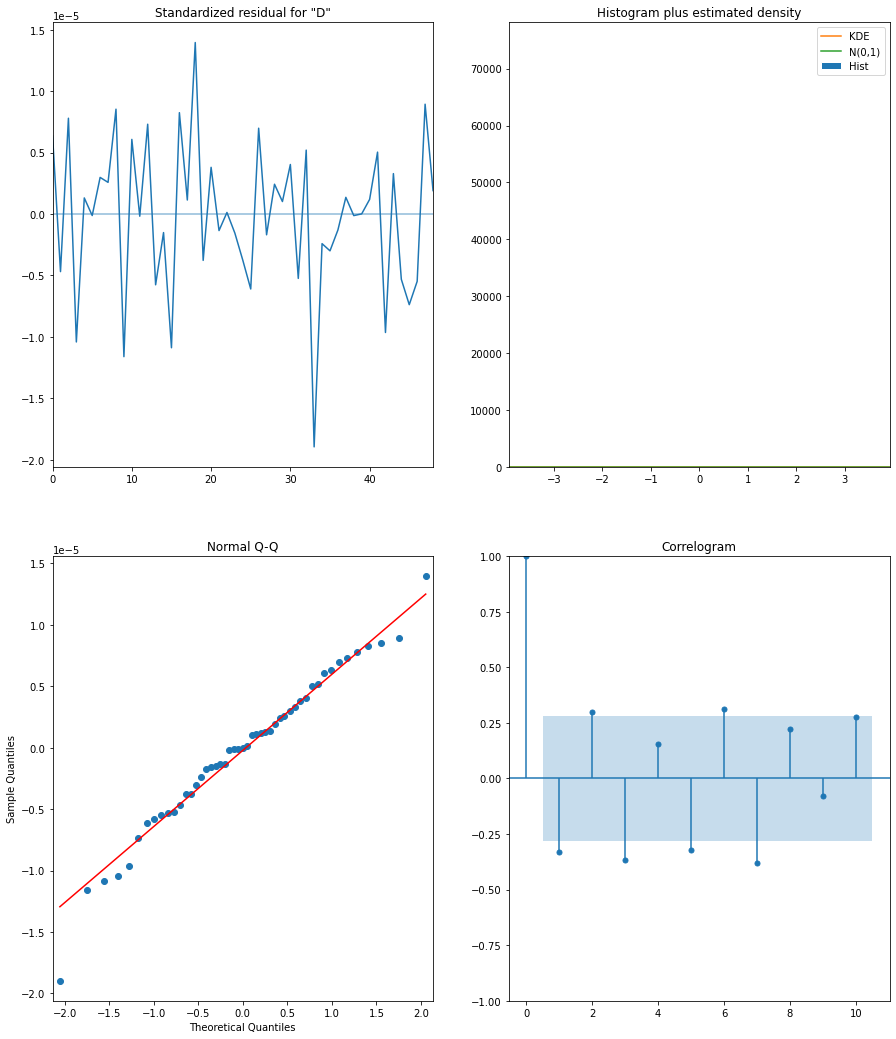

In [142]:
JH_output = sarimax(qb_list[2], qb_list_snaps[2], order=(0, 0, 1), seasonal_order=(0, 1, 1, 17))

The RMSE of our forecasts is 7.76


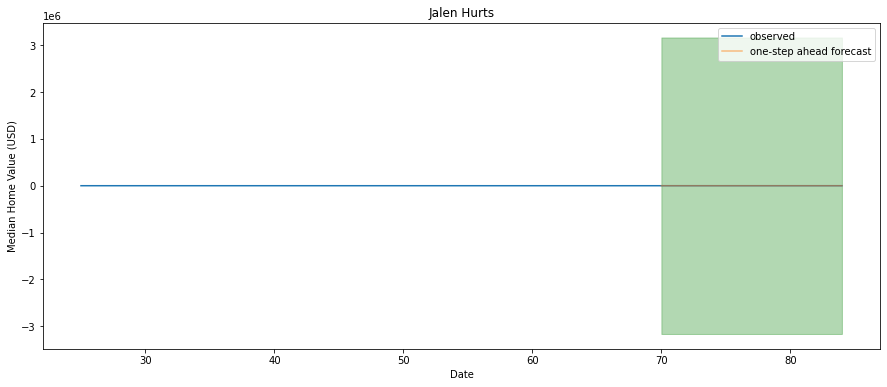

In [143]:
ose_forecast(qb_list[2], JH_output, qb_list_snaps[2][70:], player ='Jalen Hurts')

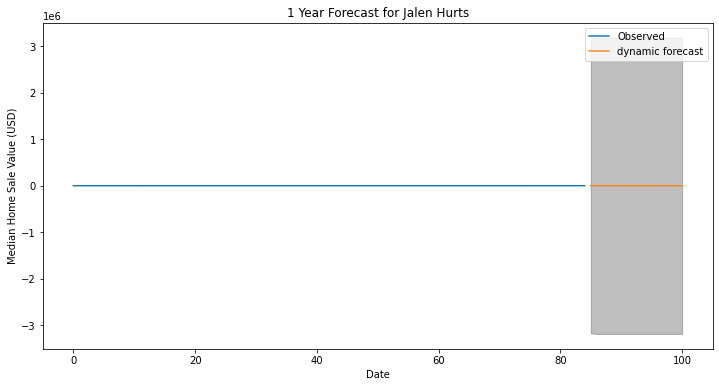

{'forecast': 85     23.0
 86     12.0
 87     17.0
 88     32.0
 89     25.0
 90     20.0
 91     18.0
 92     18.0
 93     20.0
 94     28.0
 95      7.0
 96     24.0
 97     17.0
 98      8.0
 99      8.0
 100    32.0
 Name: predicted_mean, dtype: float64,
 'minimum': -3182808.0,
 'maximum': 3182873.0}

In [144]:
dynamic_forecast(qb_list[2], JH_output, qb_list_snaps[2][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[2][-16:].mean()),
                 16, player='Jalen Hurts', save_fig=False)


#### Joe Burrow

                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
snaps_Derek Carr     0.2550        nan        nan        nan         nan         nan
ma.L1               -0.0616         -0        inf      0.000      -0.062      -0.062
ma.S.L17          4.722e+13   1.09e-32   4.33e+45      0.000    4.72e+13    4.72e+13
sigma2            5.362e-13   2.71e-10      0.002      0.998   -5.31e-10    5.32e-10


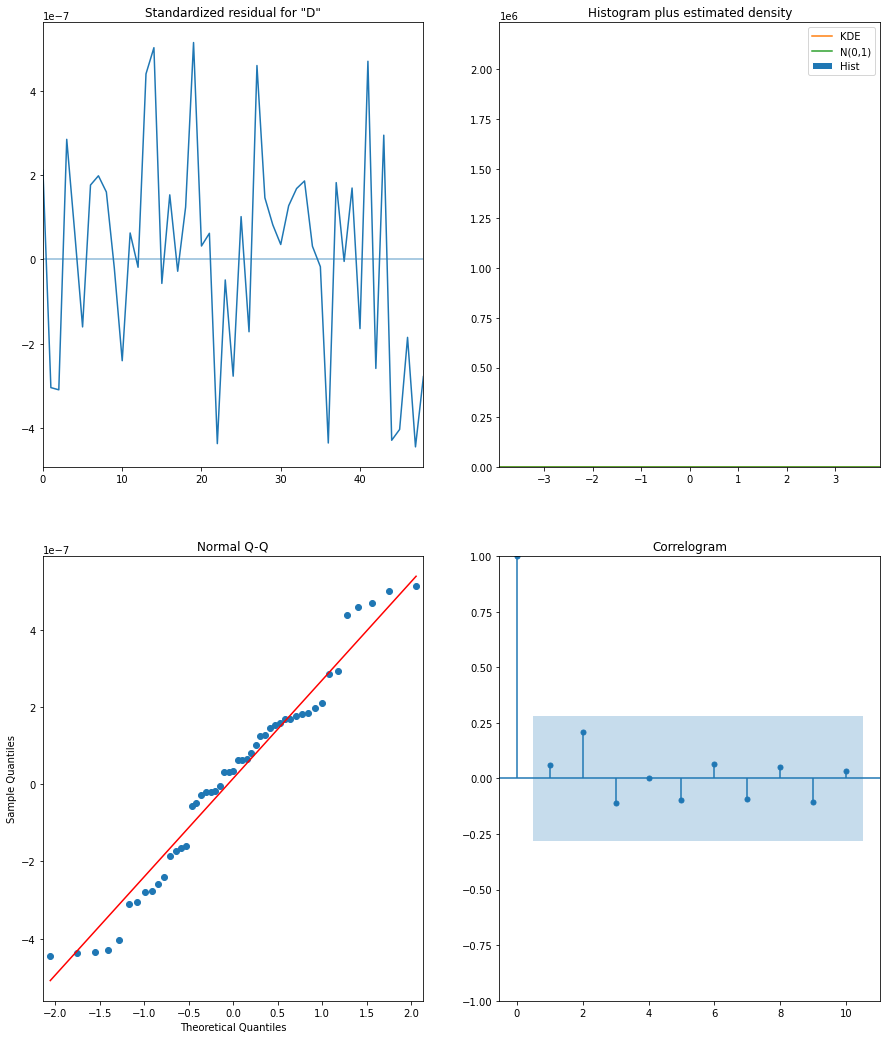

In [145]:
JB_output = sarimax(qb_list[3], qb_list_snaps[3], order=(0, 0, 1), seasonal_order=(0, 1, 1, 17))

The RMSE of our forecasts is 10.21


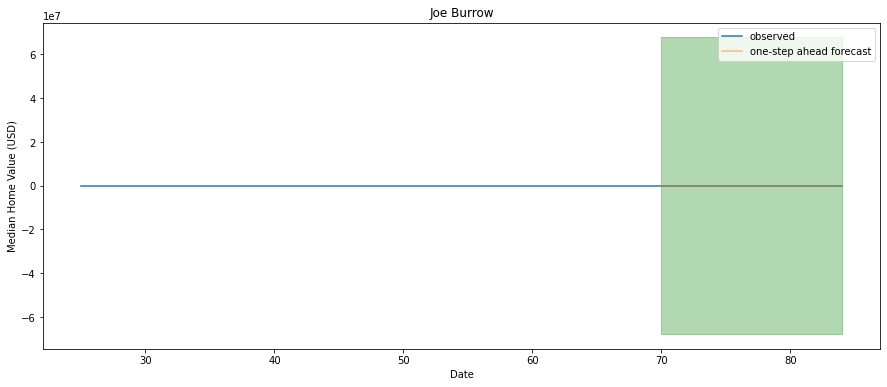

In [146]:
ose_forecast(qb_list[3], JB_output, qb_list_snaps[3][70:], player ='Joe Burrow')

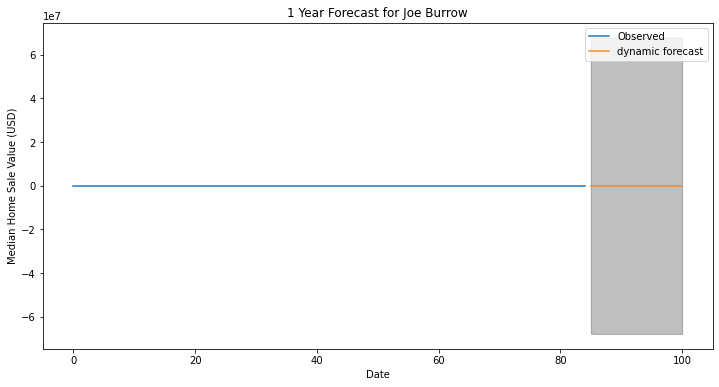

{'forecast': 85     20.0
 86     29.0
 87     16.0
 88     17.0
 89      6.0
 90     24.0
 91     18.0
 92     17.0
 93      9.0
 94     17.0
 95     20.0
 96     14.0
 97     13.0
 98     13.0
 99     11.0
 100     7.0
 Name: predicted_mean, dtype: float64,
 'minimum': -67898041.0,
 'maximum': 67898056.0}

In [147]:
dynamic_forecast(qb_list[3], JB_output, qb_list_snaps[3][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[3].mean()),
                 16, player='Joe Burrow', save_fig=False)


#### Josh Allen

                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
snaps_Deshaun Watson     0.3296      0.043      7.712      0.000       0.246       0.413
ar.L1                    0.7671      0.078      9.780      0.000       0.613       0.921
ma.L1                   -1.1978      0.217     -5.511      0.000      -1.624      -0.772
ar.S.L16                -0.3488      0.221     -1.575      0.115      -0.783       0.085
ma.S.L16                -0.5765      0.550     -1.048      0.295      -1.654       0.501
sigma2                  39.5736     17.774      2.226      0.026       4.737      74.410


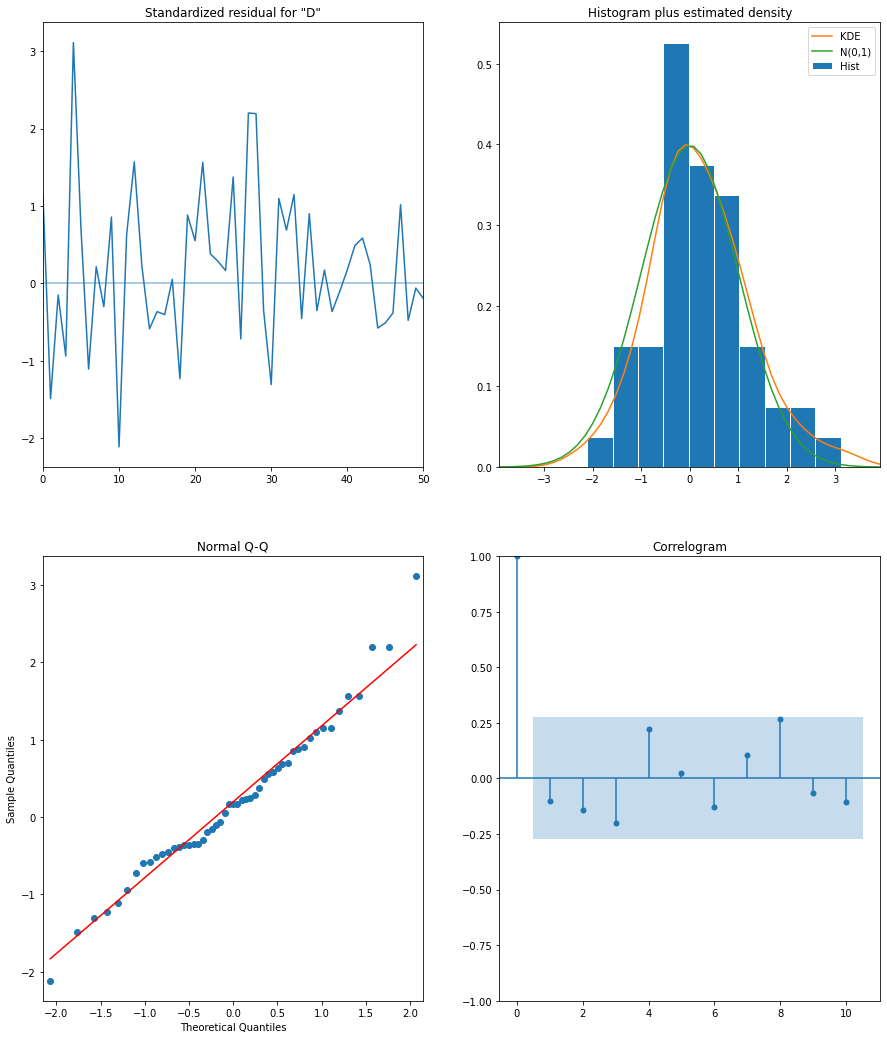

In [148]:
JA_output = sarimax(qb_list[4], qb_list_snaps[4], order=(1, 0, 1), seasonal_order=(1, 1, 1, 16))

The RMSE of our forecasts is 3.41


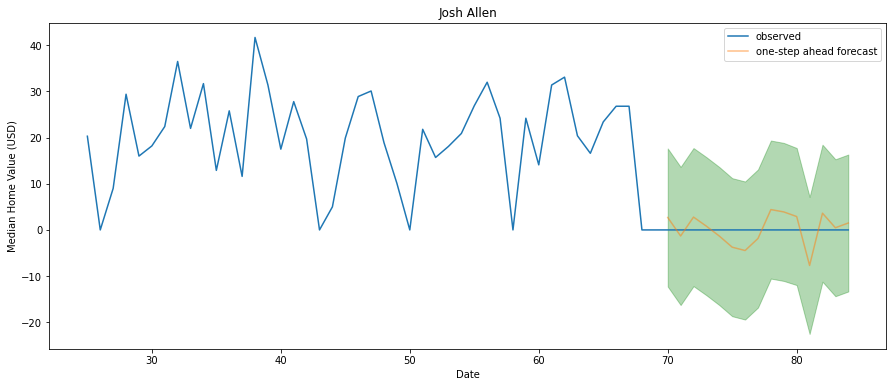

In [149]:
ose_forecast(qb_list[4], JA_output, qb_list_snaps[4][70:], player ='Josh Allen')

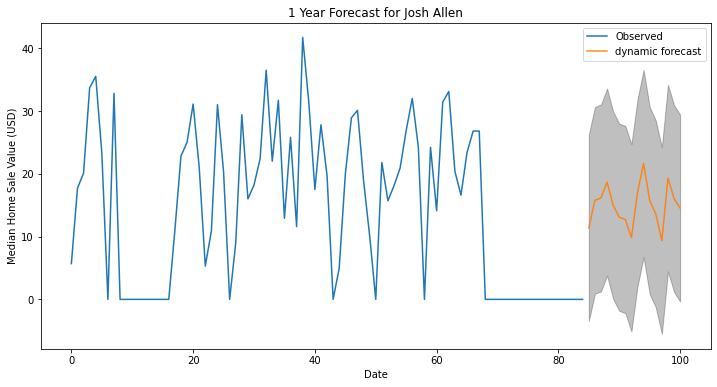

{'forecast': 85     11.0
 86     16.0
 87     16.0
 88     19.0
 89     15.0
 90     13.0
 91     13.0
 92     10.0
 93     17.0
 94     22.0
 95     16.0
 96     14.0
 97      9.0
 98     19.0
 99     16.0
 100    15.0
 Name: predicted_mean, dtype: float64,
 'minimum': -0.0,
 'maximum': 29.0}

In [150]:
dynamic_forecast(qb_list[4], JA_output, qb_list_snaps[4][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[4].mean()),
                 16, player='Josh Allen', save_fig=False)


#### Justin Herbert

                           coef    std err          z      P>|z|      [0.025      0.975]
----------------------------------------------------------------------------------------
snaps_Jameis Winston     0.2341         -0       -inf      0.000       0.234       0.234
ma.L1                   -0.6952         -0        inf      0.000      -0.695      -0.695
ar.S.L17                 0.0851   9.49e-33   8.96e+30      0.000       0.085       0.085
ma.S.L17             -6.683e+13   7.81e-33  -8.56e+45      0.000   -6.68e+13   -6.68e+13
sigma2                4.867e-12   2.74e-10      0.018      0.986   -5.33e-10    5.43e-10


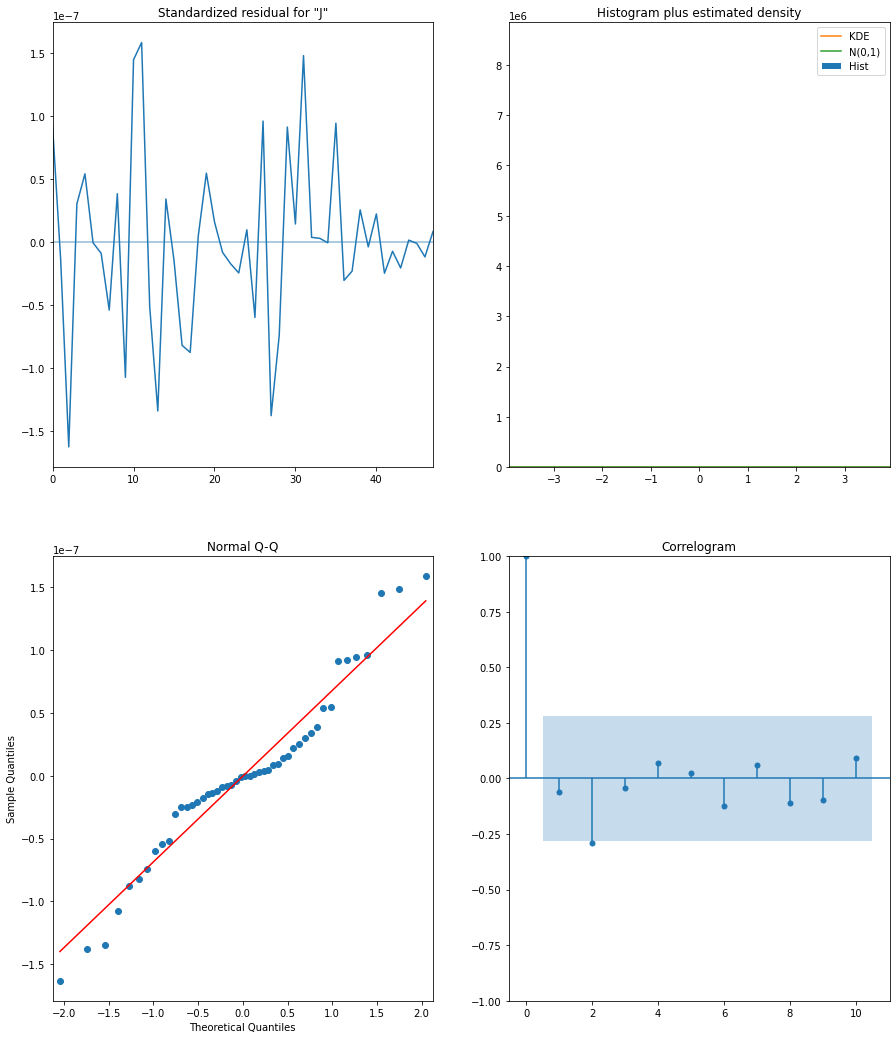

In [151]:
JH2_output = sarimax(qb_list[5], qb_list_snaps[5], order=(0, 1, 1), seasonal_order=(1, 1, 1, 17))

The RMSE of our forecasts is 4.32


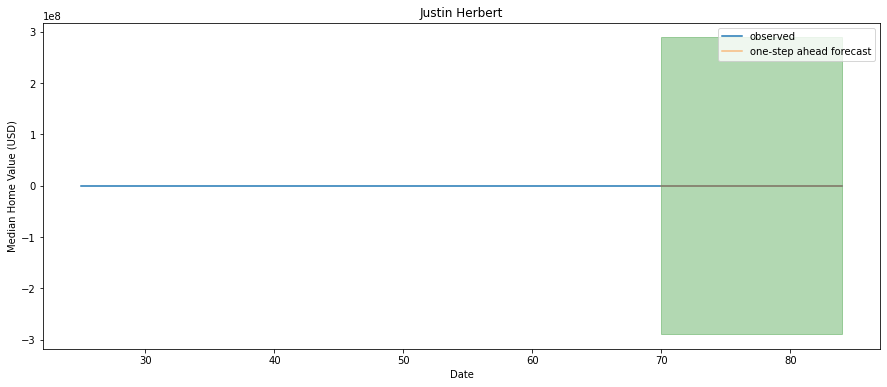

In [152]:
ose_forecast(qb_list[5], JH2_output, qb_list_snaps[5][70:], player ='Justin Herbert')

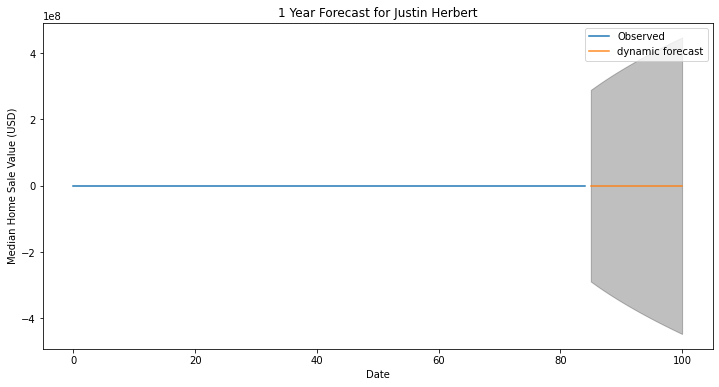

{'forecast': 85     28.0
 86     16.0
 87     15.0
 88     13.0
 89     25.0
 90     19.0
 91      6.0
 92     16.0
 93     10.0
 94     10.0
 95     10.0
 96     10.0
 97     10.0
 98     10.0
 99     10.0
 100    10.0
 Name: predicted_mean, dtype: float64,
 'minimum': -447014615.0,
 'maximum': 447014634.0}

In [153]:
dynamic_forecast(qb_list[5], JH2_output, qb_list_snaps[5][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[5].mean()),
                 16, player='Justin Herbert', save_fig=False)


#### Kyler Murray

                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
snaps_Josh Allen     0.2905      0.052      5.534      0.000       0.188       0.393
ar.L1                0.1246      0.164      0.761      0.447      -0.196       0.446
ma.L1               -1.0000   2404.493     -0.000      1.000   -4713.719    4711.719
ar.S.L16            -0.4011      0.304     -1.318      0.188      -0.998       0.196
ma.S.L16            -0.3443      0.363     -0.948      0.343      -1.056       0.368
sigma2              62.7070   1.51e+05      0.000      1.000   -2.95e+05    2.96e+05


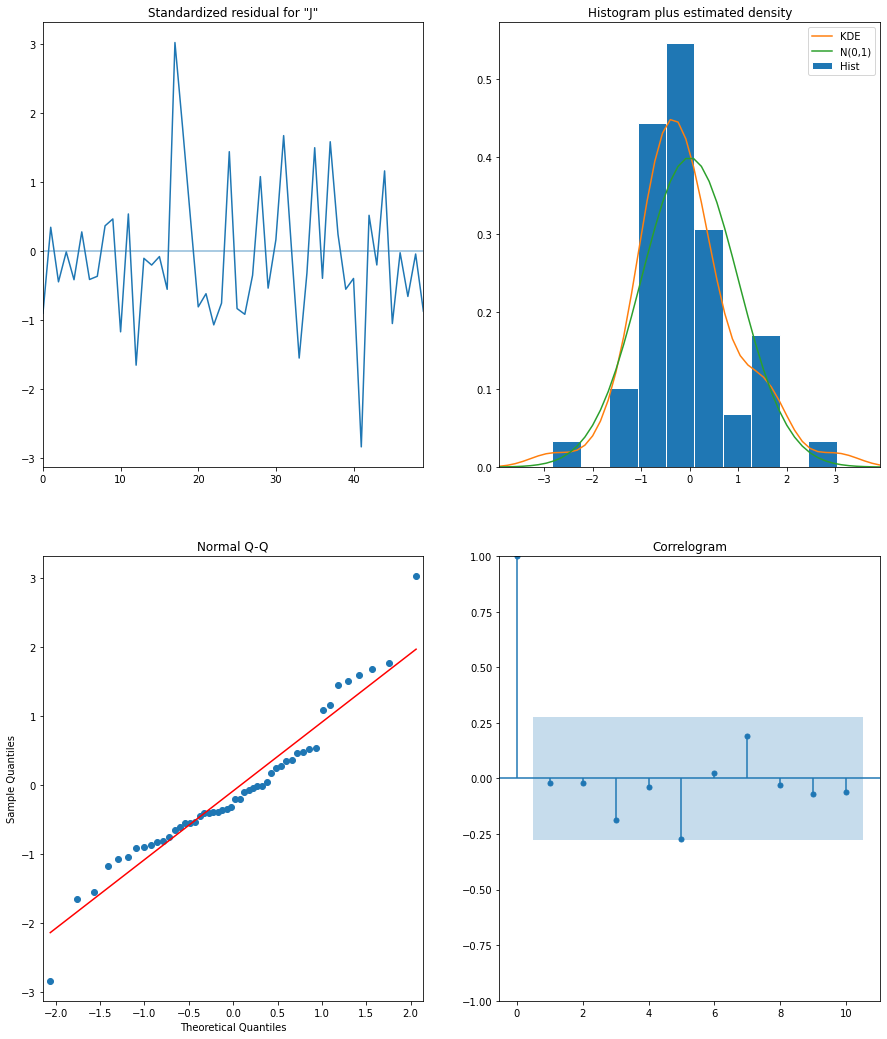

In [154]:
KM_output = sarimax(qb_list[6], qb_list_snaps[6], order=(1, 1, 1), seasonal_order=(1, 1, 1, 16))

The RMSE of our forecasts is 8.68


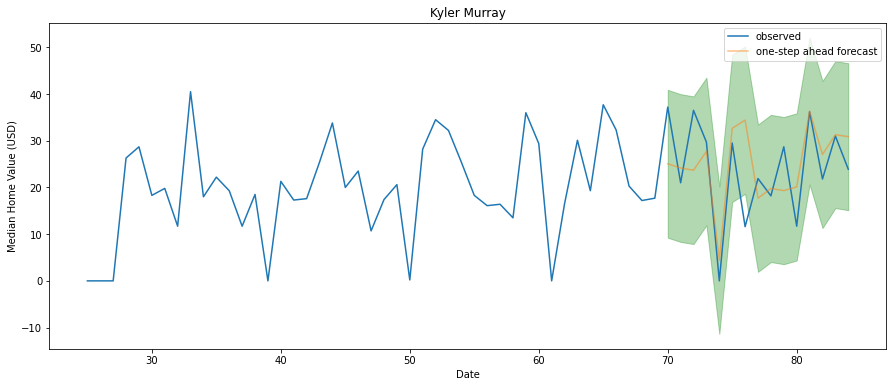

In [155]:
ose_forecast(qb_list[6], KM_output, qb_list_snaps[6][70:], player ='Kyler Murray')

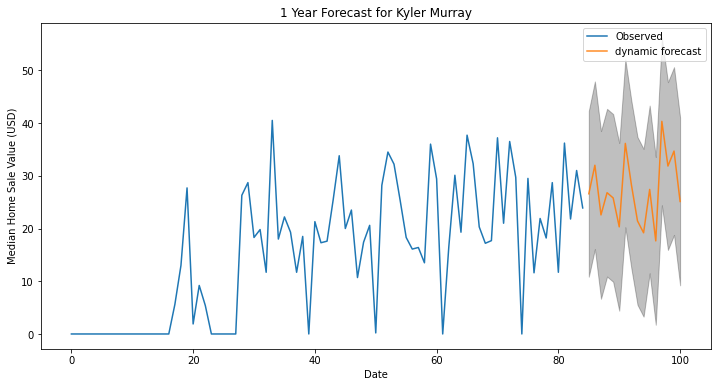

{'forecast': 85     27.0
 86     32.0
 87     23.0
 88     27.0
 89     26.0
 90     20.0
 91     36.0
 92     28.0
 93     21.0
 94     19.0
 95     27.0
 96     18.0
 97     40.0
 98     32.0
 99     35.0
 100    25.0
 Name: predicted_mean, dtype: float64,
 'minimum': 9.0,
 'maximum': 41.0}

In [156]:
dynamic_forecast(qb_list[6], KM_output, qb_list_snaps[6][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[6][-16:].mean()),
                 16, player='Kyler Murray', save_fig=False)


#### Lamar Jackson

                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
snaps_Kirk Cousins     0.3236      0.048      6.749      0.000       0.230       0.418
ar.L1                 -0.1765      0.139     -1.271      0.204      -0.449       0.096
ma.L1                 -1.0000    467.774     -0.002      0.998    -917.820     915.820
ar.S.L17              -0.4442      0.133     -3.338      0.001      -0.705      -0.183
sigma2                46.7609   2.19e+04      0.002      0.998   -4.28e+04    4.29e+04


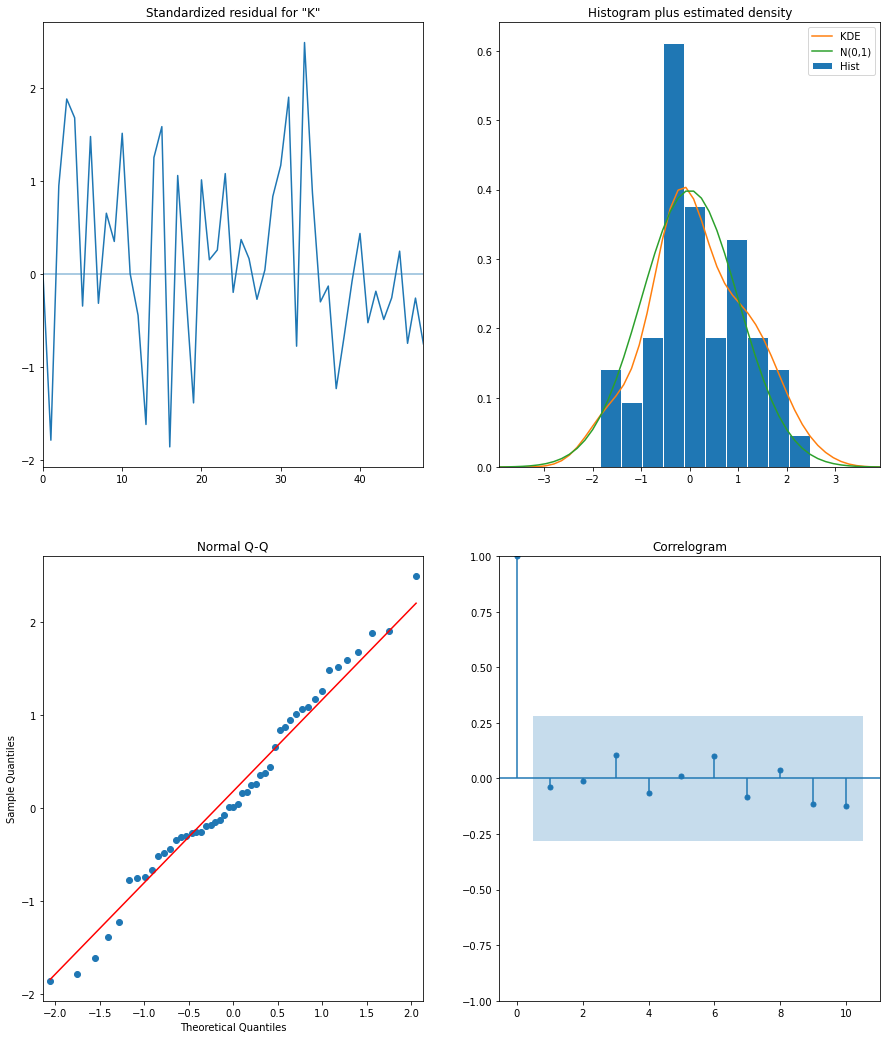

In [157]:
LJ_output = sarimax(qb_list[7], qb_list_snaps[7], order=(1, 1, 1), seasonal_order=(1, 1, 0, 17))

The RMSE of our forecasts is 3.95


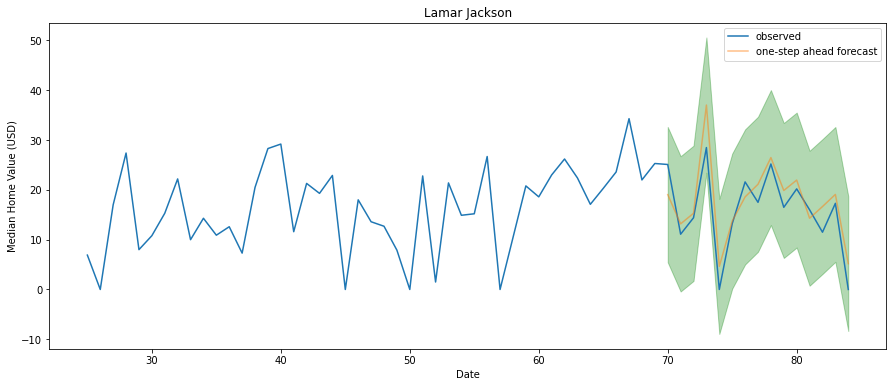

In [158]:
ose_forecast(qb_list[7], LJ_output, qb_list_snaps[7][70:], player ='Lamar Jackson')

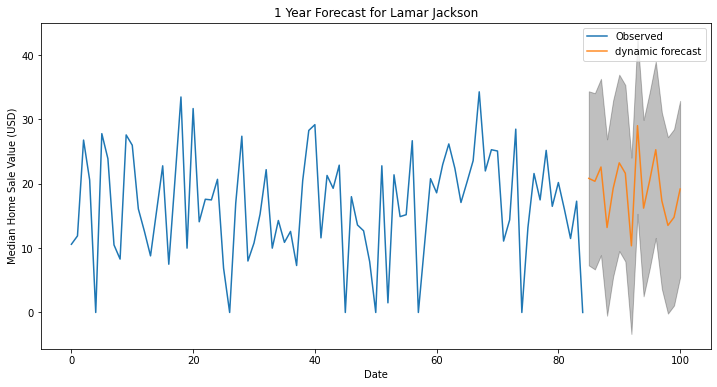

{'forecast': 85     21.0
 86     20.0
 87     23.0
 88     13.0
 89     19.0
 90     23.0
 91     22.0
 92     10.0
 93     29.0
 94     16.0
 95     21.0
 96     25.0
 97     17.0
 98     14.0
 99     15.0
 100    19.0
 Name: predicted_mean, dtype: float64,
 'minimum': 5.0,
 'maximum': 33.0}

In [159]:
dynamic_forecast(qb_list[7], LJ_output, qb_list_snaps[7][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[7][-16:].mean()),
                 16, player='Lamar Jackson', save_fig=False)


#### Matthew Stafford

                         coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------
snaps_Kyler Murray     0.3145      0.041      7.679      0.000       0.234       0.395
ar.L1                  0.2303      0.174      1.327      0.184      -0.110       0.571
ma.L1                 -1.0000    507.775     -0.002      0.998    -996.222     994.222
ar.S.L17              -0.6763      0.171     -3.950      0.000      -1.012      -0.341
sigma2                56.0422   2.85e+04      0.002      0.998   -5.57e+04    5.58e+04


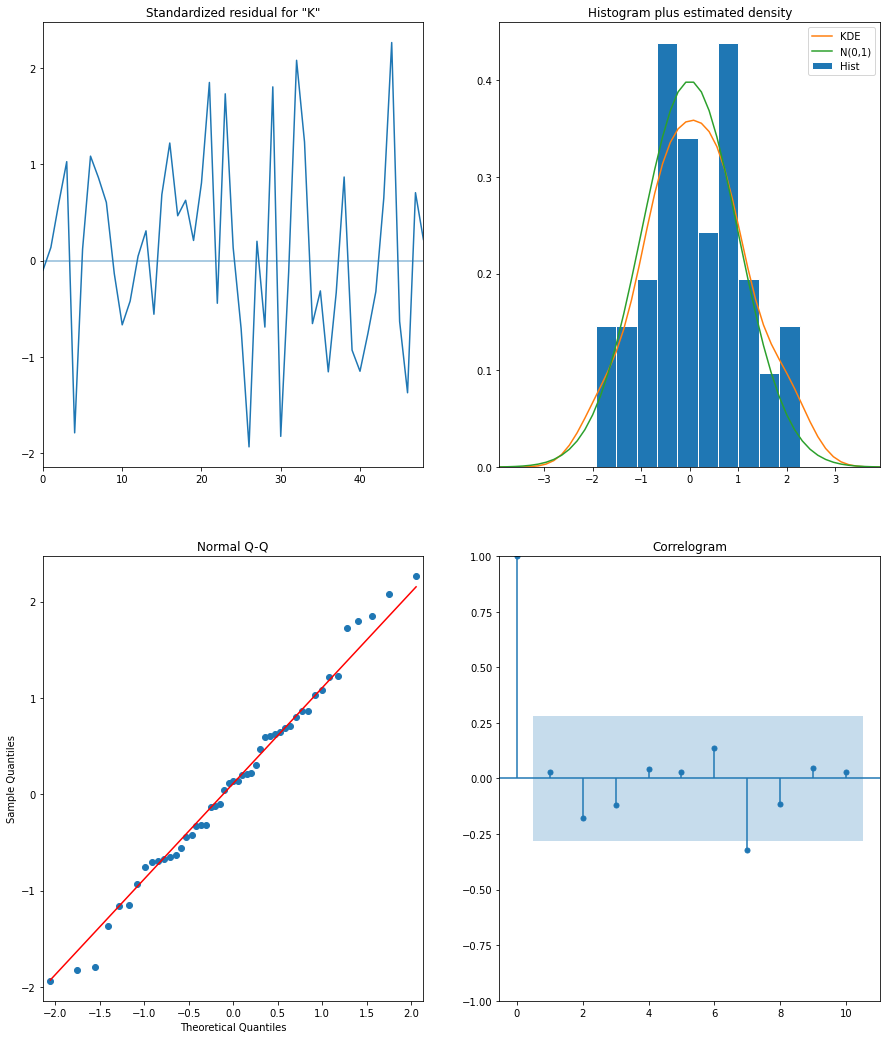

In [160]:
MS_output = sarimax(qb_list[8], qb_list_snaps[8], order=(1, 1, 1), seasonal_order=(1, 1, 0, 17))

The RMSE of our forecasts is 7.3


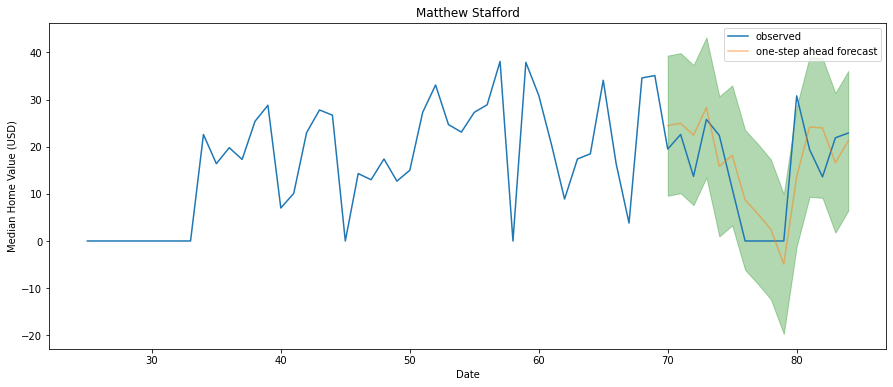

In [161]:
ose_forecast(qb_list[8], MS_output, qb_list_snaps[8][70:], player ='Matthew Stafford')

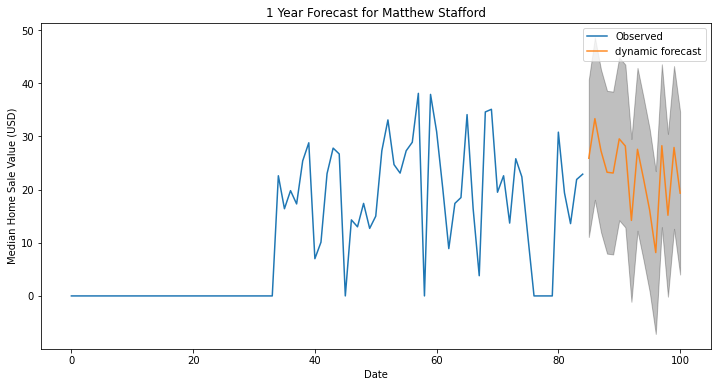

{'forecast': 85     26.0
 86     33.0
 87     27.0
 88     23.0
 89     23.0
 90     30.0
 91     28.0
 92     14.0
 93     28.0
 94     22.0
 95     16.0
 96      8.0
 97     28.0
 98     15.0
 99     28.0
 100    19.0
 Name: predicted_mean, dtype: float64,
 'minimum': 4.0,
 'maximum': 35.0}

In [162]:
dynamic_forecast(qb_list[8], MS_output, qb_list_snaps[8][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[8][-16:].mean()),
                 16, player='Matthew Stafford', save_fig=False)

#### Patrick Mahomes II

                          coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------
snaps_Lamar Jackson     0.3191      0.051      6.245      0.000       0.219       0.419
ar.L1                   0.2627      0.132      1.993      0.046       0.004       0.521
ar.S.L17               -0.4441      0.201     -2.210      0.027      -0.838      -0.050
sigma2                111.5695     22.627      4.931      0.000      67.221     155.918


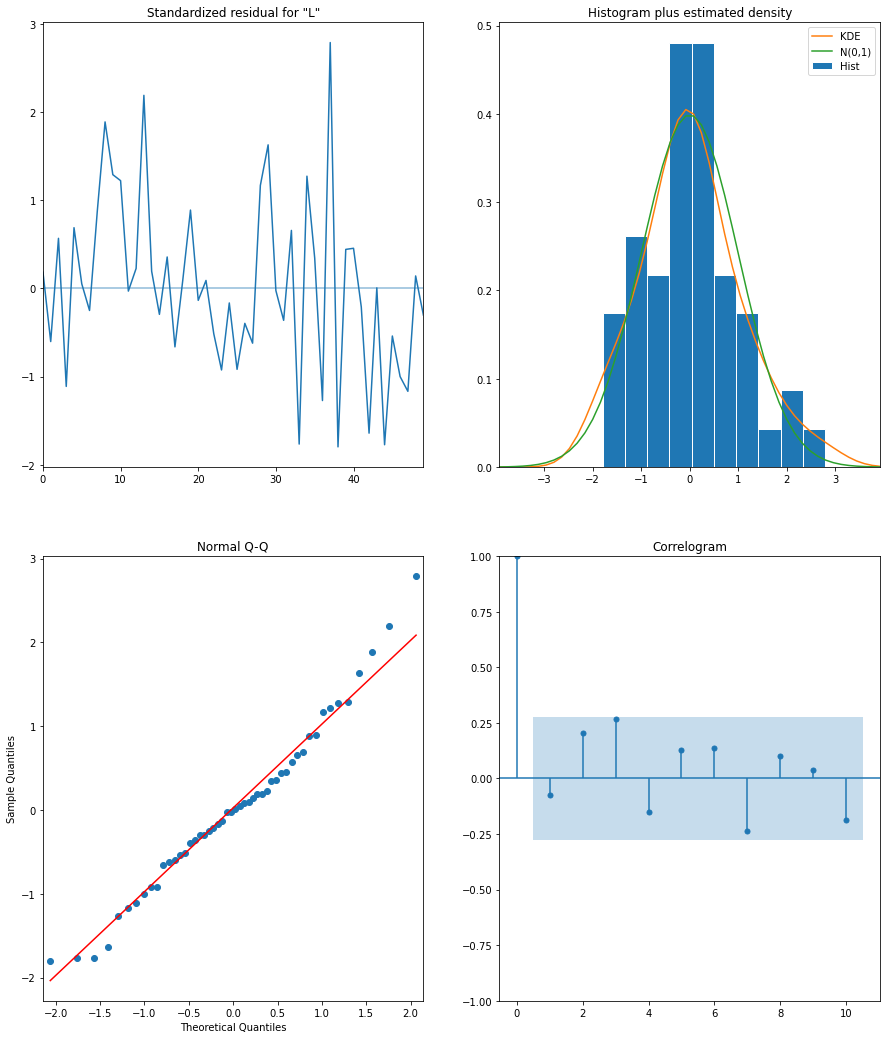

In [163]:
PM_output = sarimax(qb_list[9], qb_list_snaps[9], order=(1, 0, 0), seasonal_order=(1, 1, 0, 17))

The RMSE of our forecasts is 12.73


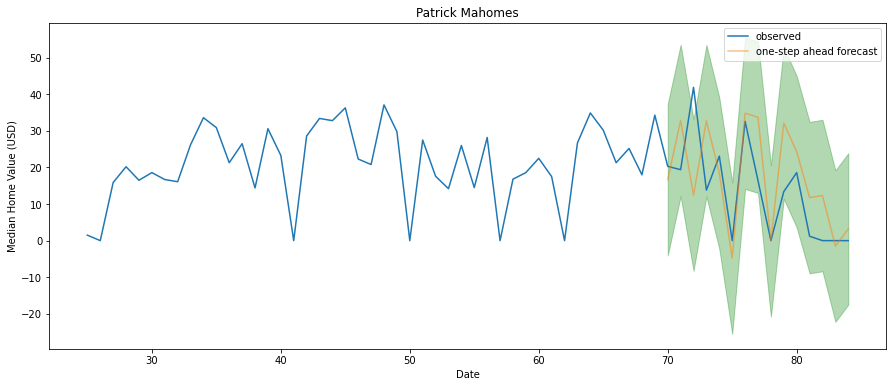

In [164]:
ose_forecast(qb_list[9], PM_output, qb_list_snaps[9][70:], player ='Patrick Mahomes')

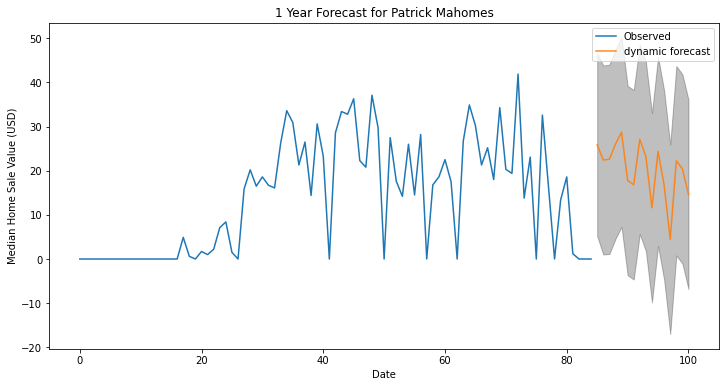

{'forecast': 85     26.0
 86     22.0
 87     23.0
 88     26.0
 89     29.0
 90     18.0
 91     17.0
 92     27.0
 93     23.0
 94     12.0
 95     24.0
 96     17.0
 97      4.0
 98     22.0
 99     20.0
 100    15.0
 Name: predicted_mean, dtype: float64,
 'minimum': -7.0,
 'maximum': 36.0}

In [165]:
dynamic_forecast(qb_list[9], PM_output, qb_list_snaps[9][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[9][-16:].mean()),
                 16, player='Patrick Mahomes', save_fig=False)

#### Russell Wilson

                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
snaps_Matt Ryan     0.2899      0.059      4.943      0.000       0.175       0.405
ma.L1              -1.0000    787.541     -0.001      0.999   -1544.551    1542.551
ar.S.L16           -0.3815      0.152     -2.514      0.012      -0.679      -0.084
ma.S.L16           -0.3164      0.231     -1.372      0.170      -0.768       0.136
sigma2             51.6809   4.07e+04      0.001      0.999   -7.97e+04    7.98e+04


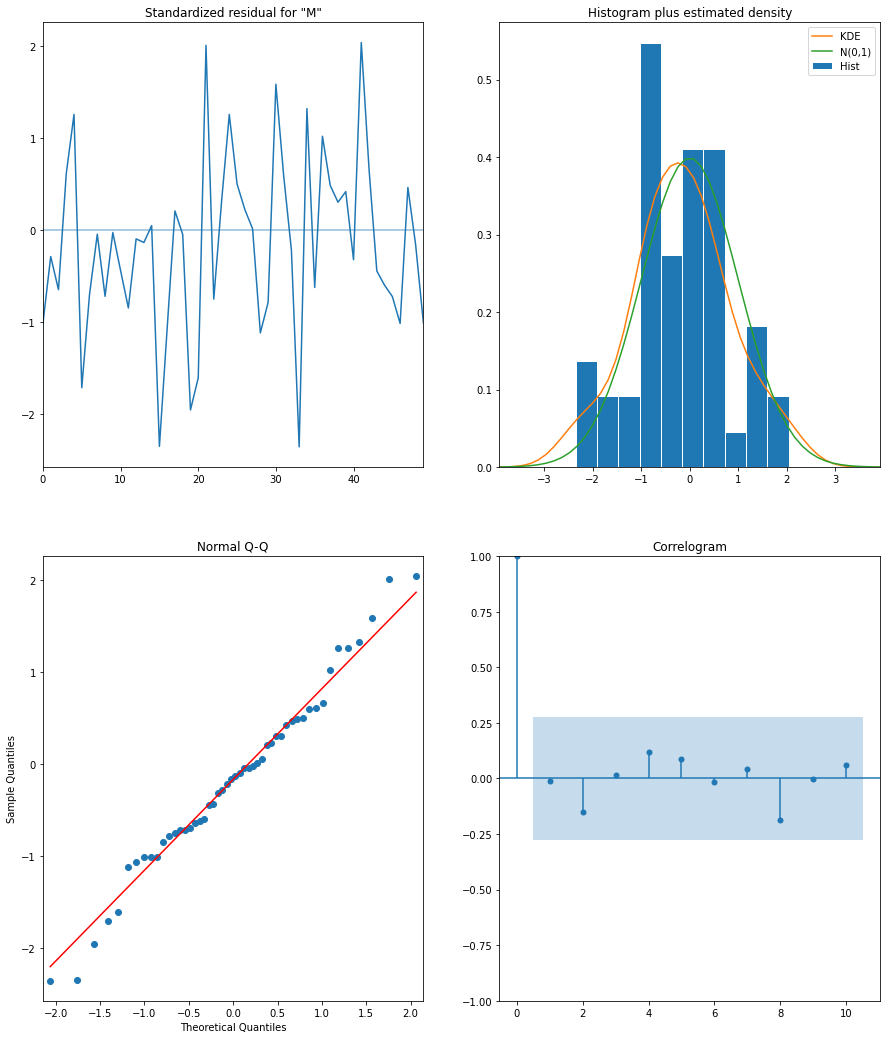

In [166]:
RW_output = sarimax(qb_list[10], qb_list_snaps[10], order=(0, 1, 1), seasonal_order=(1, 1, 1, 16))

The RMSE of our forecasts is 5.96


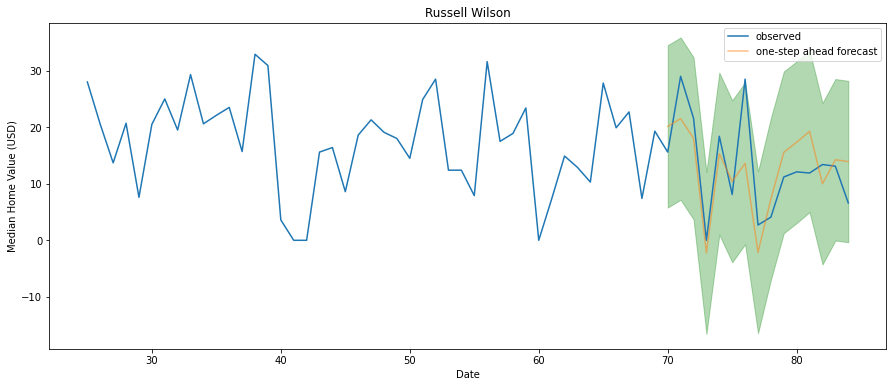

In [167]:
ose_forecast(qb_list[10], RW_output, qb_list_snaps[10][70:], player ='Russell Wilson')

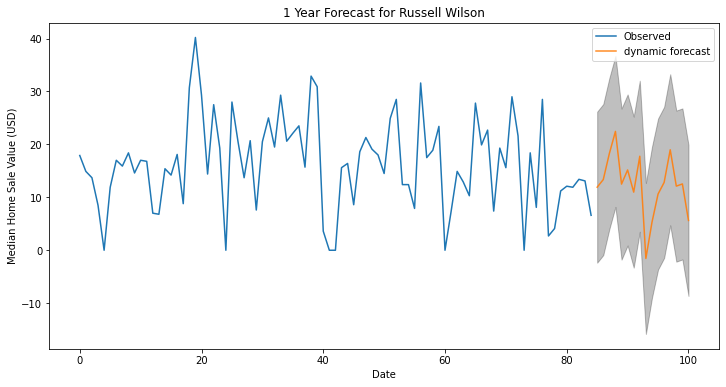

{'forecast': 85     12.0
 86     13.0
 87     18.0
 88     22.0
 89     12.0
 90     15.0
 91     11.0
 92     18.0
 93     -2.0
 94      5.0
 95     11.0
 96     13.0
 97     19.0
 98     12.0
 99     13.0
 100     6.0
 Name: predicted_mean, dtype: float64,
 'minimum': -9.0,
 'maximum': 20.0}

In [168]:
dynamic_forecast(qb_list[10], RW_output, qb_list_snaps[10][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[10][-16:].mean()),
                 16, player='Russell Wilson', save_fig=False)

#### Tom Brady

                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
snaps_Matthew Stafford     0.2614      0.025     10.655      0.000       0.213       0.310
ar.L1                      0.0755      0.175      0.432      0.666      -0.267       0.418
ma.L1                     -1.0000    706.132     -0.001      0.999   -1384.994    1382.994
ar.S.L17                  -0.5610      0.126     -4.444      0.000      -0.808      -0.314
sigma2                    29.5553   2.09e+04      0.001      0.999   -4.09e+04    4.09e+04


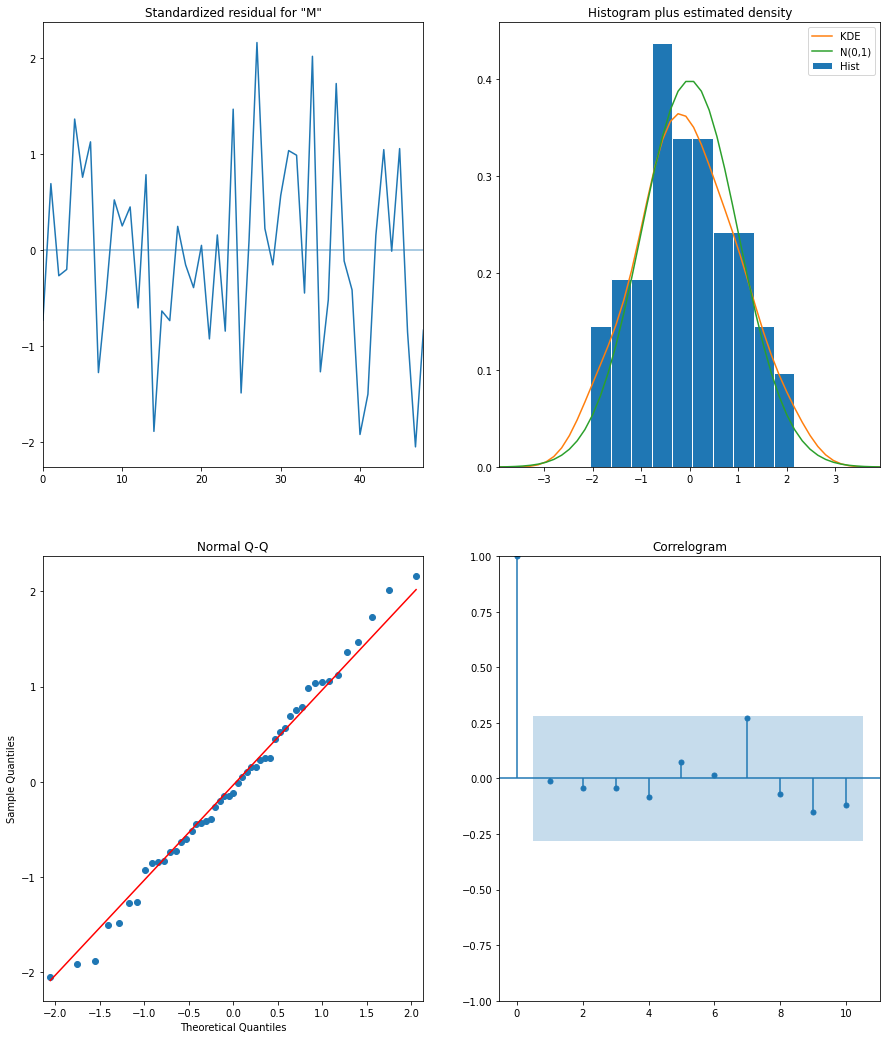

In [169]:
TB_output = sarimax(qb_list[11], qb_list_snaps[11], order=(1, 1, 1), seasonal_order=(1, 1, 0, 17))

The RMSE of our forecasts is 6.79


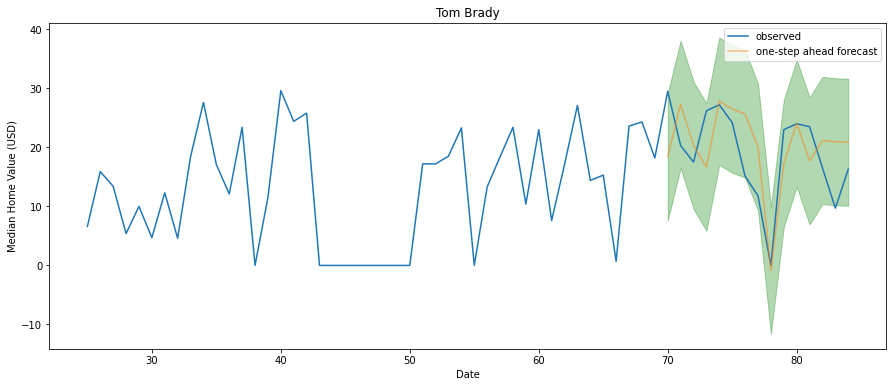

In [170]:
ose_forecast(qb_list[11], TB_output, qb_list_snaps[11][70:], player ='Tom Brady')

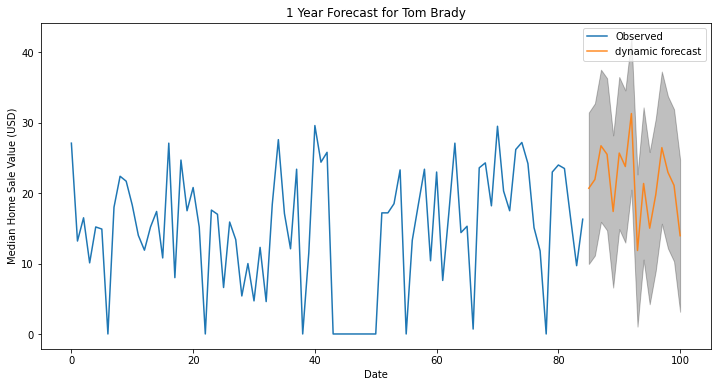

{'forecast': 85     21.0
 86     22.0
 87     27.0
 88     26.0
 89     17.0
 90     26.0
 91     24.0
 92     31.0
 93     12.0
 94     21.0
 95     15.0
 96     20.0
 97     26.0
 98     23.0
 99     21.0
 100    14.0
 Name: predicted_mean, dtype: float64,
 'minimum': 3.0,
 'maximum': 25.0}

In [171]:
dynamic_forecast(qb_list[11], TB_output, qb_list_snaps[11][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[11][-16:].mean()),
                 16, player='Tom Brady', save_fig=False)


#### Trey Lance

                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
snaps_Patrick Mahomes II     0.3587        nan        nan        nan         nan         nan
ar.L1                        0.9124   1870.897      0.000      1.000   -3665.978    3667.803
ma.L1                       -1.4065      0.716     -1.963      0.050      -2.811      -0.002
ar.S.L17                    -0.7375      2.810     -0.262      0.793      -6.245       4.770
ma.S.L17                 -5.347e+13   2.07e-08  -2.59e+21      0.000   -5.35e+13   -5.35e+13
sigma2                      92.9809     34.610      2.686      0.007      25.146     160.816


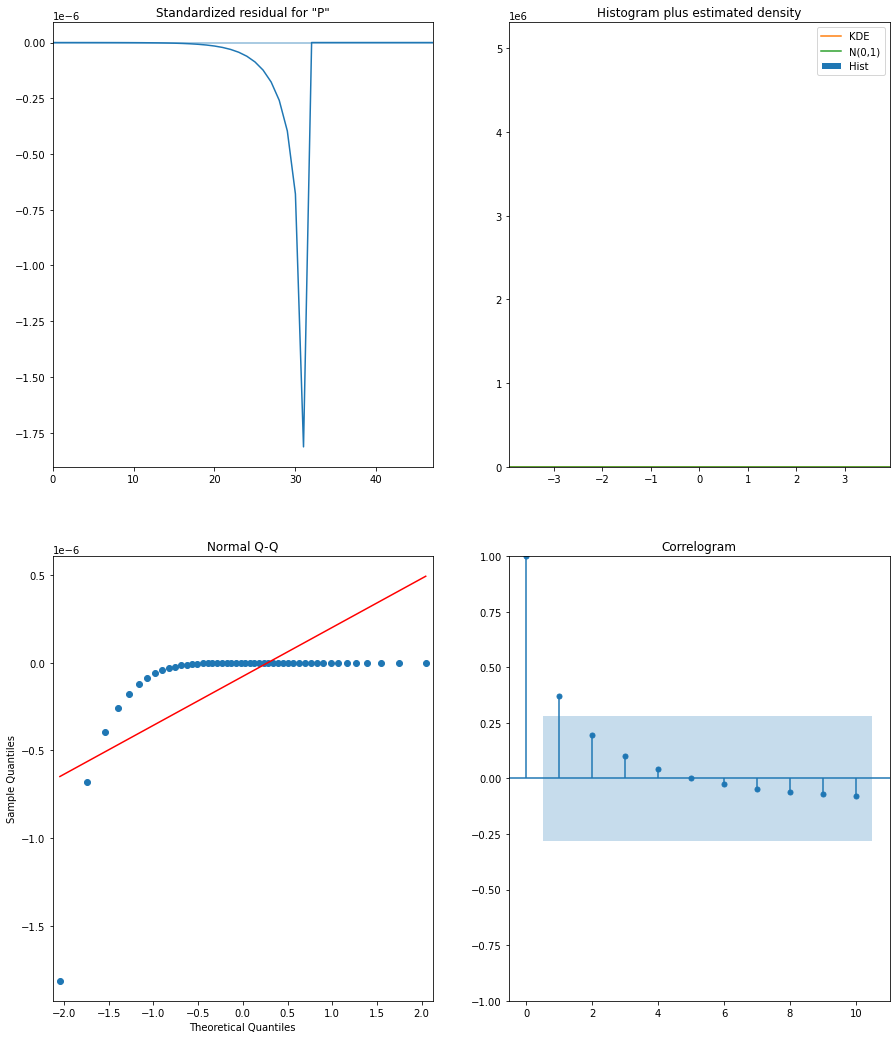

In [172]:
TL_output = sarimax(qb_list[12], qb_list_snaps[12], order=(1, 1, 1), seasonal_order=(1, 1, 1, 17))

The RMSE of our forecasts is 13839763563.04


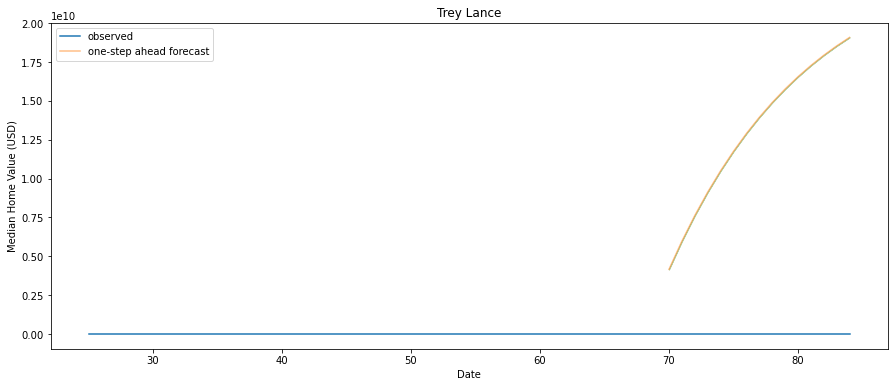

In [173]:
ose_forecast(qb_list[12], TL_output, qb_list_snaps[12][70:], player ='Trey Lance')

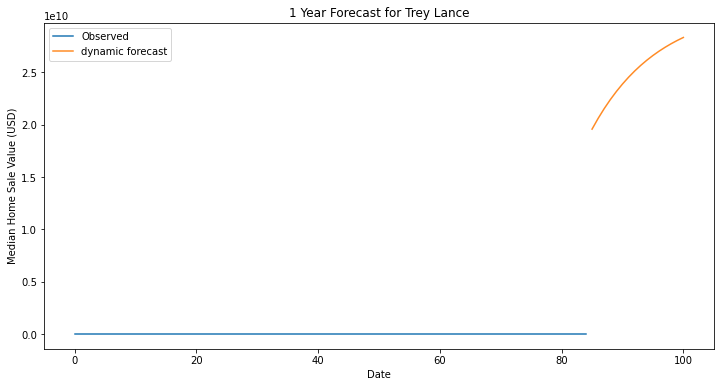

{'forecast': 85     1.958092e+10
 86     2.060839e+10
 87     2.154584e+10
 88     2.240114e+10
 89     2.318149e+10
 90     2.389347e+10
 91     2.454306e+10
 92     2.513573e+10
 93     2.567647e+10
 94     2.616983e+10
 95     2.661996e+10
 96     2.703064e+10
 97     2.740534e+10
 98     2.774721e+10
 99     2.805912e+10
 100    2.834370e+10
 Name: predicted_mean, dtype: float64,
 'minimum': nan,
 'maximum': nan}

In [174]:
dynamic_forecast(qb_list[12], TL_output, qb_list_snaps[12][-16:]
                 .replace(to_replace = 0, value = qb_list_snaps[12][-16:].mean()),
                 16, player='Trey Lance', save_fig=False)


#### Raheem Mostert

                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
snaps_Ronald Jones II     0.3950      0.009     42.345      0.000       0.377       0.413
ma.L1                    -0.2954      0.092     -3.213      0.001      -0.476      -0.115
sigma2                    9.9221      1.079      9.195      0.000       7.807      12.037


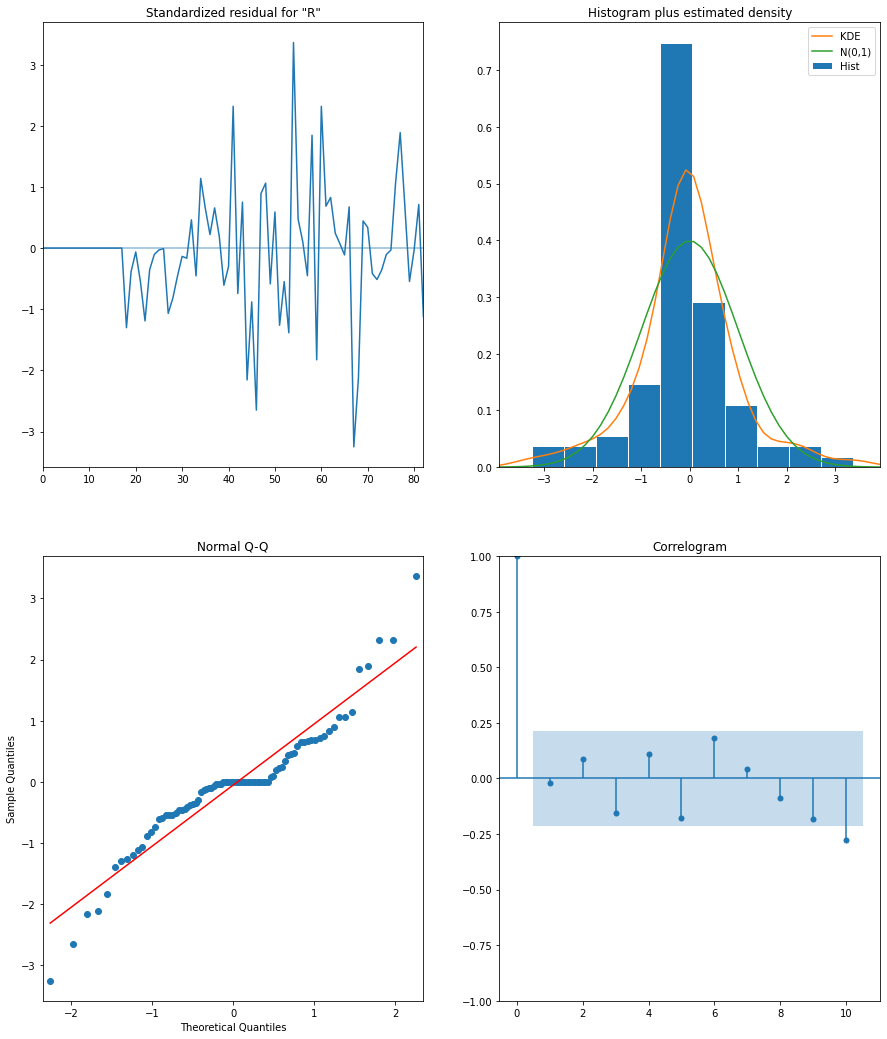

In [213]:
RM_output = sarimax(rb_list[25], rb_list_snaps[25], order=(0, 0, 1), seasonal_order=(0, 0, 0, 0))


The RMSE of our forecasts is 0.08


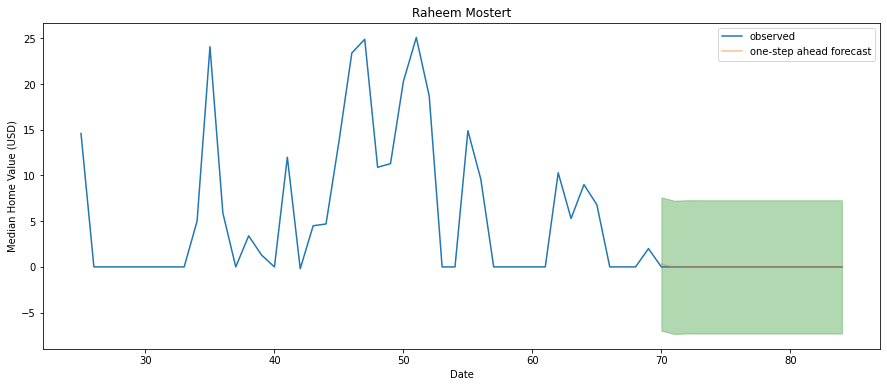

In [198]:
ose_forecast(rb_list[25], RM_output, rb_list_snaps[25][70:], player ='Raheem Mostert')

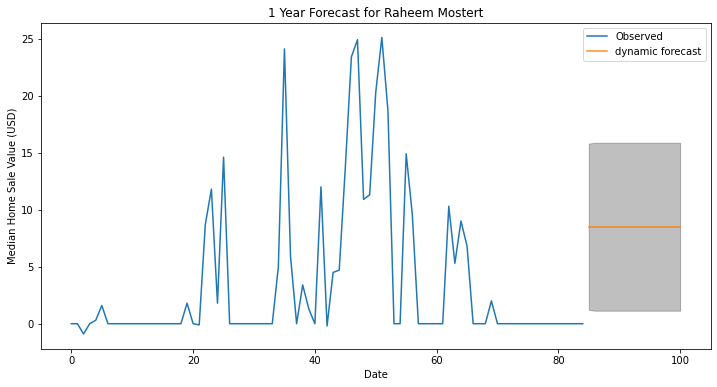

{'forecast': 85     9.0
 86     9.0
 87     9.0
 88     9.0
 89     9.0
 90     9.0
 91     9.0
 92     9.0
 93     9.0
 94     9.0
 95     9.0
 96     9.0
 97     9.0
 98     9.0
 99     9.0
 100    9.0
 Name: predicted_mean, dtype: float64,
 'minimum': 1.0,
 'maximum': 16.0}

In [203]:
dynamic_forecast(rb_list[25], RM_output, rb_list_snaps[25][-16:]
                 .replace(to_replace = 0, value = 20),
                 16, player='Raheem Mostert', save_fig=False)

In [202]:
pd.set_option('max_row', 100)
rb_list[25]

0      0.0
1      0.0
2     -0.9
3      0.0
4      0.3
5      1.6
6      0.0
7      0.0
8      0.0
9      0.0
10     0.0
11     0.0
12     0.0
13     0.0
14     0.0
15     0.0
16     0.0
17     0.0
18     0.0
19     1.8
20     0.0
21    -0.1
22     8.7
23    11.8
24     1.8
25    14.6
26     0.0
27     0.0
28     0.0
29     0.0
30     0.0
31     0.0
32     0.0
33     0.0
34     5.0
35    24.1
36     5.9
37     0.0
38     3.4
39     1.3
40     0.0
41    12.0
42    -0.2
43     4.5
44     4.7
45    13.7
46    23.4
47    24.9
48    10.9
49    11.3
50    20.3
51    25.1
52    18.7
53     0.0
54     0.0
55    14.9
56     9.6
57     0.0
58     0.0
59     0.0
60     0.0
61     0.0
62    10.3
63     5.3
64     9.0
65     6.8
66     0.0
67     0.0
68     0.0
69     2.0
70     0.0
71     0.0
72     0.0
73     0.0
74     0.0
75     0.0
76     0.0
77     0.0
78     0.0
79     0.0
80     0.0
81     0.0
82     0.0
83     0.0
84     0.0
Name: Raheem Mostert, dtype: float64

## Facebook Prophet Modeling

In [95]:
qb_fb_list = []
for col in qb_ts.columns:
    player = qb_ts[col].squeeze()
    qb_fb_list.append(player)

qb_fb_list[0]

0     16.5
1     18.5
2     24.8
3     23.1
4     24.0
      ... 
80     0.0
81    29.6
82    23.8
83    20.0
84    20.3
Name: Aaron Rodgers, Length: 85, dtype: float64

In [96]:
# Set the uncertainty interval to 95% (the Prophet default is 80%)
Model = proph(interval_width=0.95)

In [97]:
# Rename the columns [Month, AirPassengers] to [ds, y]
qb_fb_list[0] = qb_fb_list[0].reset_index().rename(columns={'Date': 'ds',
                                                     'Aaron Rodgers': 'y'})
qb_fb_list[0]

,index,y
0,0,16.5
1,1,18.5
2,2,24.8
3,3,23.1
4,4,24.0
...,...,...
80,80,0.0
81,81,29.6
82,82,23.8
83,83,20.0


In [98]:
bye = [6, 23, 44, 55, 76]
qb_fb_list[0] = qb_fb_list[0].drop(bye).fillna(0)
qb_fb_list[0]

,index,y
0,0,16.5
1,1,18.5
2,2,24.8
3,3,23.1
4,4,24.0
...,...,...
80,80,0.0
81,81,29.6
82,82,23.8
83,83,20.0


In [99]:
# Fit the timeseries to Model
Model.fit(qb_fb_list[0])

ValueError: Dataframe must have columns "ds" and "y" with the dates and values respectively.

In [ ]:
# Use make_future_dataframe() with a monthly frequency and periods = 36 for 3 years
future_dates = Model.make_future_dataframe(periods=16, freq='W')
future_dates.head()

In [ ]:
# Predict the values for future dates and take the head of forecast
forecast = Model.predict(future_dates)
forecast.head()

In [ ]:
# Use Prophet's plot method to plot the predictions
Model.plot(forecast, uncertainty=True)
plt.show()

In [ ]:
m = proph()
m.fit(qb_fb_list[0])

#%% Forecast 1 year
weeks = 16
future = m.make_future_dataframe(periods=weeks)
future.tail()

fig1 = m.plot(forecast)
plt.close()
fig2 = m.plot_components(forecast)


## Interpret Results

In [31]:
qb_list

[0     16.5
 1     18.5
 2     24.8
 3     23.1
 4     24.0
       ... 
 80     0.0
 81    29.6
 82    23.8
 83    20.0
 84    20.3
 Name: Aaron Rodgers, Length: 85, dtype: float64,
 0     17.1
 1     15.9
 2     22.9
 3     22.6
 4     29.7
       ... 
 80    12.2
 81    11.9
 82    10.6
 83    31.3
 84    23.0
 Name: Dak Prescott, Length: 85, dtype: float64,
 0      0.0
 1      0.0
 2      0.0
 3      0.0
 4      0.0
       ... 
 80     0.0
 81     0.0
 82    28.6
 83    16.7
 84    13.0
 Name: Jalen Hurts, Length: 85, dtype: float64,
 0      0.0
 1      0.0
 2      0.0
 3      0.0
 4      0.0
       ... 
 80    18.6
 81    22.2
 82    12.8
 83    38.1
 84    34.8
 Name: Joe Burrow, Length: 85, dtype: float64,
 0      0.0
 1      0.0
 2      0.0
 3      0.0
 4      0.0
       ... 
 80    11.7
 81    36.2
 82    21.8
 83    31.0
 84    23.9
 Name: Josh Allen, Length: 85, dtype: float64,
 0      0.0
 1      0.0
 2      0.0
 3      0.0
 4      0.0
       ... 
 80    26.3
 81    24.9
 82

### Projections for 2022 Season

I am now going to make a dataframe that will contain our projected metrics based upon our sarimax model forecasting.

In [214]:
def projections(ts, exog_ts):
    
    '''
    Calculate projections for each zip code.
        - Current Value
        - ROI (return on investment)
        
    Input:
        ts : time series data.
        zipcodes : list of zip codes to iterate through.
        years : n-number of years to forecast.
        
    Output:
        Returns dataframe with:
        - zip code
        - investment value (current value)
        - predicted value and errors
        - predicted ROI and errors

    '''
       
    # Time series of zip code
    player_list = []
    for col in ts.columns:
        player_name = ts[col].squeeze()
        player_list.append(player_name)
               
    player_list_names = []
    for col in ts.columns:
        player_name = col
        player_list_names.append(player_name)    
            
    player_list_snaps = []
    for col in exog_ts.columns:
        player_name = exog_ts[col].squeeze()
        player_list_snaps.append(player_name)
        
        # Define the p, d and q parameters to take any value between 0 and 2
        p = d = q = range(0, 2)
        # Generate all different combinations of p, q and q triplets
        pdq = list(itertools.product(p, d, q))
        # Generate all different combinations of seasonal p, q and q triplets
        pdqs = [(x[0], x[1], x[2], 0) for x in list(itertools.product(p, d, q))]
    
        # Run a grid with pdq and seasonal pdq parameters calculated above and get the best AIC value
        ans = []
        for df, name, snaps in zip(player_list, player_list_names, player_list_snaps):
            for comb in pdq:
                for combs in pdqs:
                    try:
                        mod = sm.tsa.statespace.SARIMAX(df,
                                                        exog=snaps,
                                                        order=comb,
                                                        seasonal_order=combs,
                                                        enforce_stationarity=False,
                                                        enforce_invertibility=False)

                        output = mod.fit()
                        ans.append([name, comb, combs, output.aic])
                    except:
                        continue

        # Find the parameters with minimal AIC value
        ans_df = pd.DataFrame(ans, columns=['name', 'pdq', 'pdqs', 'aic'])
        best_para = ans_df.loc[ans_df.groupby("name")["aic"].idxmin()]
        
        # Create list to append projection metrics
        projections = []
        
        # Iterate through time series of each zip code
    
        for df, name, snaps, pdq, pdqs in zip(player_list, player_list_names, player_list_snaps, best_para['pdq'], best_para['pdqs']):
            try:                      
               
                # Plug the optimal parameter values into a new SARIMAX model
                # I used the values that were the most frequent for out top 10 zipcodes
                SARIMAX = sm.tsa.statespace.SARIMAX(df,
                                                    exog=snaps,
                                                    order=pdq,
                                                    seasonal_order=pdqs,
                                                    enforce_stationarity=False,
                                                    enforce_invertibility=False)
    

                # Fit the model and print results
                output = SARIMAX.fit()
 
                # Get forecast and confidence interval for steps ahead in future
                forecast = output.get_forecast(steps=16, exog=snaps[-16:].replace(to_replace = 0, value = 61), dynamic=True)
                conf_int = forecast.conf_int()

                # Show prediction for end of step-period
            
                pred_mean = forecast.predicted_mean.sum()
                pred_mean_min = conf_int.iloc[:,0].sum()
                pred_mean_max = conf_int.iloc[:,1].sum()
        
                # Create DataFrame
        
                # Initiate empty dictionary
                predicted = {}

                # Columns for df
                predicted['Player'] = name
                predicted['Projected Points'] = pred_mean.round(0)
                predicted['Min Projected Points'] = pred_mean_min.round(0)
                predicted['Max Projected Points'] = pred_mean_max.round(0)
                
                # Append to list
                projections.append(predicted)
            except:
                continue
        
    # Return in DataFrame format     
    return pd.DataFrame(projections)

In [185]:
qb_2022_projections = projections(qb_ts, qb_snap_ts)
qb_2022_projections = qb_2022_projections.sort_values('Projected Points', ascending=False)
qb_2022_projections

,Player,Projected Points,Min Projected Points,Max Projected Points
6,Josh Allen,384.0,163.0,605.0
12,Patrick Mahomes II,377.0,159.0,594.0
0,Aaron Rodgers,343.0,116.0,570.0
8,Kyler Murray,342.0,171.0,513.0
4,Deshaun Watson,336.0,131.0,540.0
15,Tom Brady,336.0,87.0,585.0
2,Dak Prescott,322.0,81.0,564.0
7,Kirk Cousins,300.0,114.0,486.0
13,Russell Wilson,290.0,82.0,499.0
11,Matthew Stafford,285.0,82.0,488.0


In [215]:
rb_2022_projections = projections(rb_ts, rb_snap_ts)
rb_2022_projections = rb_2022_projections.sort_values('Projected Points', ascending=False)
rb_2022_projections

,Player,Projected Points,Min Projected Points,Max Projected Points
9,Derrick Henry,416.0,112.0,719.0
4,Christian McCaffrey,357.0,119.0,595.0
1,Alvin Kamara,356.0,29.0,684.0
2,Austin Ekeler,341.0,135.0,546.0
6,Dalvin Cook,297.0,61.0,534.0
0,Aaron Jones,290.0,8.0,572.0
23,Nick Chubb,284.0,66.0,501.0
17,Kareem Hunt,283.0,70.0,497.0
15,Joe Mixon,277.0,93.0,460.0
8,David Montgomery,272.0,108.0,436.0


In [187]:
wr_2022_projections = projections(wr_ts, wr_snap_ts)
wr_2022_projections = wr_2022_projections.sort_values('Projected Points', ascending=False)
wr_2022_projections

,Player,Projected Points,Min Projected Points,Max Projected Points
12,Davante Adams,377.0,112.0,642.0
7,Cooper Kupp,371.0,106.0,635.0
28,Michael Thomas,333.0,128.0,538.0
39,Tyreek Hill,315.0,-15.0,645.0
15,Diontae Johnson,282.0,129.0,435.0
21,Keenan Allen,277.0,45.0,509.0
13,DeAndre Hopkins,265.0,46.0,484.0
35,Stefon Diggs,262.0,13.0,510.0
29,Mike Evans,257.0,-18.0,531.0
5,Chris Godwin,253.0,21.0,485.0


In [217]:
te_2022_projections = projections(te_ts, te_snap_ts)
te_2022_projections = te_2022_projections.sort_values('Projected Points', ascending=False)
te_2022_projections

,Player,Projected Points,Min Projected Points,Max Projected Points
14,Travis Kelce,275.0,49.0,501.0
9,Mark Andrews,271.0,55.0,487.0
5,George Kittle,270.0,38.0,501.0
2,Darren Waller,229.0,57.0,401.0
12,Robert Tonyan,189.0,49.0,330.0
13,T.J. Hockenson,185.0,51.0,319.0
0,Dallas Goedert,167.0,19.0,316.0
10,Mike Gesicki,165.0,-11.0,341.0
16,Zach Ertz,160.0,-63.0,384.0
11,Noah Fant,157.0,18.0,296.0


### Barplots of 2022 Season Projections and Errors

In [ ]:
# Barplot for x years projection with 95% confidence intervals
def projection_barplot(df, years=3, save_fig=False):
    # Plot Predicted Mean Home Sale Values #

    # Get errors; (pred mean - lower bound of conf interval)
    errors = df['Predicted ROI (%)'] - df['Min Pred ROI (%)']
    df['errors'] = errors

    # Define figure, axes, and plot
    fig, ax = plt.subplots(figsize=(16, 6))
    
    # Plot barplot of ROI with errors
    plt.rcParams.update({'font.size': 18})
    df.plot(x='Neighborhood', 
            y='Predicted ROI (%)', 
            kind='bar',
            ax=ax, 
            color='none', 
            ecolor='black',
            capsize=10,
            yerr='errors', 
            legend=False)
    #Labels
    ax.set_xlabel('Neighborhood')
    ax.set_ylabel('Predicted ROI (%)')
    plt.title(f'{years} Year ROI w/ 95% Confidence Intervals')

    # Predicted ROI
    ax.scatter(x=pd.np.arange(df.shape[0]),
               marker='s', 
               s=40, 
               y=df['Predicted ROI (%)'], 
               color='black')
    
    # Line to help visualize on the y-axis
    ax.axhline(y=50, linestyle='--', color='red', linewidth=1.5)
    
    if save_fig:
        fig.savefig(f'./images/barplot_{years}.jpeg')
    
    # Rotate zip code labels 45 degrees
    plt.xticks(rotation = 45, size = 14)
    plt.show();

### ADP vs Projected Points

In [223]:
# load in player fantasy stats data as player_df
adp_df = pd.read_csv('data/FantasyPros_2022_Overall_ADP_Rankings.csv')
#Columns to drop
to_drop = ['Bye', 'Team', 'ESPN', 'POS', 'RTSports', 'MFL', 'Fantrax', 'FFC', 'Sleeper', 'AVG']

# Drop columns
player_adp = adp_df.drop(to_drop, axis=1).dropna().head(200)
player_adp.head(10)

,Rank,Player
0,1.0,Jonathan Taylor
1,2.0,Christian McCaffrey
2,3.0,Austin Ekeler
3,4.0,Cooper Kupp
4,5.0,Derrick Henry
5,6.0,Justin Jefferson
6,7.0,Dalvin Cook
7,8.0,Najee Harris
8,9.0,Ja'Marr Chase
9,10.0,Joe Mixon


In [231]:
qb_adp_df = pd.merge(qb_2022_projections, player_adp, how = 'left', on='Player')
qb_adp_df = qb_adp_df.drop(columns = ['Min Projected Points', 'Max Projected Points'], axis =1)
qb_adp_df

,Player,Projected Points,Rank
0,Josh Allen,384.0,24.0
1,Patrick Mahomes II,377.0,31.0
2,Aaron Rodgers,343.0,84.0
3,Kyler Murray,342.0,53.0
4,Deshaun Watson,336.0,182.0
5,Tom Brady,336.0,76.0
6,Dak Prescott,322.0,74.0
7,Kirk Cousins,300.0,116.0
8,Russell Wilson,290.0,81.0
9,Matthew Stafford,285.0,93.0


In [384]:
rb_adp_df = pd.merge(rb_2022_projections, player_adp, how = 'left', on='Player')
rb_adp_df = rb_adp_df.drop(columns = ['Min Projected Points', 'Max Projected Points'], axis =1)
rb_adp_df_100 = rb_adp_df[rb_adp_df['Rank'] <= 79].reset_index().drop('index', axis=1)
rb_adp_df_200 = rb_adp_df[rb_adp_df['Rank'] >= 80].reset_index().drop('index', axis=1)
rb_adp_df_200

,Player,Projected Points,Rank
0,Kareem Hunt,283.0,85.0
1,Darrell Henderson Jr.,259.0,124.0
2,Chase Edmonds,245.0,92.0
3,Marlon Mack,226.0,165.0
4,J.D. McKissic,216.0,145.0
5,Melvin Gordon III,213.0,101.0
6,Tony Pollard,185.0,83.0
7,Mark Ingram II,182.0,179.0
8,Jamaal Williams,178.0,157.0
9,Devin Singletary,167.0,80.0


In [369]:
wr_adp_df = pd.merge(wr_2022_projections, player_adp, how = 'left', on='Player')
wr_adp_df = wr_adp_df.drop(columns = ['Min Projected Points', 'Max Projected Points'], axis =1)
wr_adp_df_100 = wr_adp_df[wr_adp_df['Rank'] <= 80].reset_index().drop('index', axis=1)
wr_adp_df_200 = wr_adp_df[wr_adp_df['Rank'] >= 81].reset_index().drop('index', axis=1)
wr_adp_df_200

,Player,Projected Points,Rank
0,DeAndre Hopkins,265.0,87.0
1,Robert Woods,248.0,97.0
2,DJ Chark Jr.,215.0,139.0
3,Julio Jones,209.0,153.0
4,Tyler Lockett,205.0,91.0
5,Marvin Jones Jr.,204.0,193.0
6,Tyler Boyd,202.0,121.0
7,Jarvis Landry,200.0,148.0
8,Russell Gage,186.0,122.0
9,Jakobi Meyers,181.0,143.0


In [232]:
te_adp_df = pd.merge(te_2022_projections, player_adp, how = 'left', on='Player')
te_adp_df = te_adp_df.drop(columns = ['Min Projected Points', 'Max Projected Points'], axis =1)
te_adp_df

,Player,Projected Points,Rank
0,Travis Kelce,275.0,13.0
1,Mark Andrews,271.0,22.0
2,George Kittle,270.0,38.0
3,Darren Waller,229.0,44.0
4,Robert Tonyan,189.0,173.0
5,T.J. Hockenson,185.0,65.0
6,Dallas Goedert,167.0,71.0
7,Mike Gesicki,165.0,115.0
8,Zach Ertz,160.0,90.0
9,Noah Fant,157.0,160.0


In [257]:
all_list = [qb_adp_df, rb_adp_df, wr_adp_df, te_adp_df]
all_adp_df = pd.concat(all_list, axis=0, ignore_index=True).sort_values('Rank')
all_adp_df

,Player,Projected Points,Rank
17,Christian McCaffrey,357.0,2.0
19,Austin Ekeler,341.0,3.0
45,Cooper Kupp,371.0,4.0
16,Derrick Henry,416.0,5.0
20,Dalvin Cook,297.0,7.0
...,...,...,...
68,Marvin Jones Jr.,204.0,193.0
79,Robbie Anderson,145.0,194.0
43,Ronald Jones II,132.0,195.0
12,Baker Mayfield,261.0,197.0


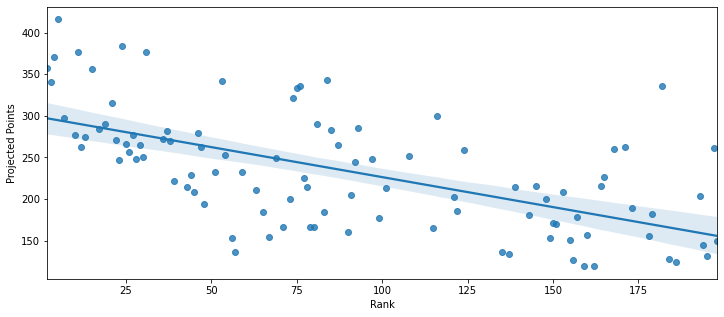

In [332]:
# Plot
fig, ax = plt.subplots(figsize=(12,5))

sns.regplot(x = 'Rank', y = 'Projected Points', data = all_adp_df);

In [450]:
def adp_plot(df, position = ''):
    plt.figure(figsize=(20,15))
    p1 = sns.regplot('Rank', 'Projected Points', data=df, ci=None)

    for line in range(0,df.shape[0]):
         p1.text(df['Rank'][line]+0.2, df['Projected Points'][line], 
         df['Player'][line], ha='left', bbox={'facecolor':'white','alpha':1,'edgecolor':'none','pad':1},
         size='x-large', color='black', weight='normal')

    plt.title(f'ADP vs 2022 {position} Projections', fontsize=25)
    # Set x-axis label
    plt.xlabel('ADP', fontsize=20)
    # Set y-axis label
    plt.ylabel('Projected Points', fontsize=20);
    return adp_plot

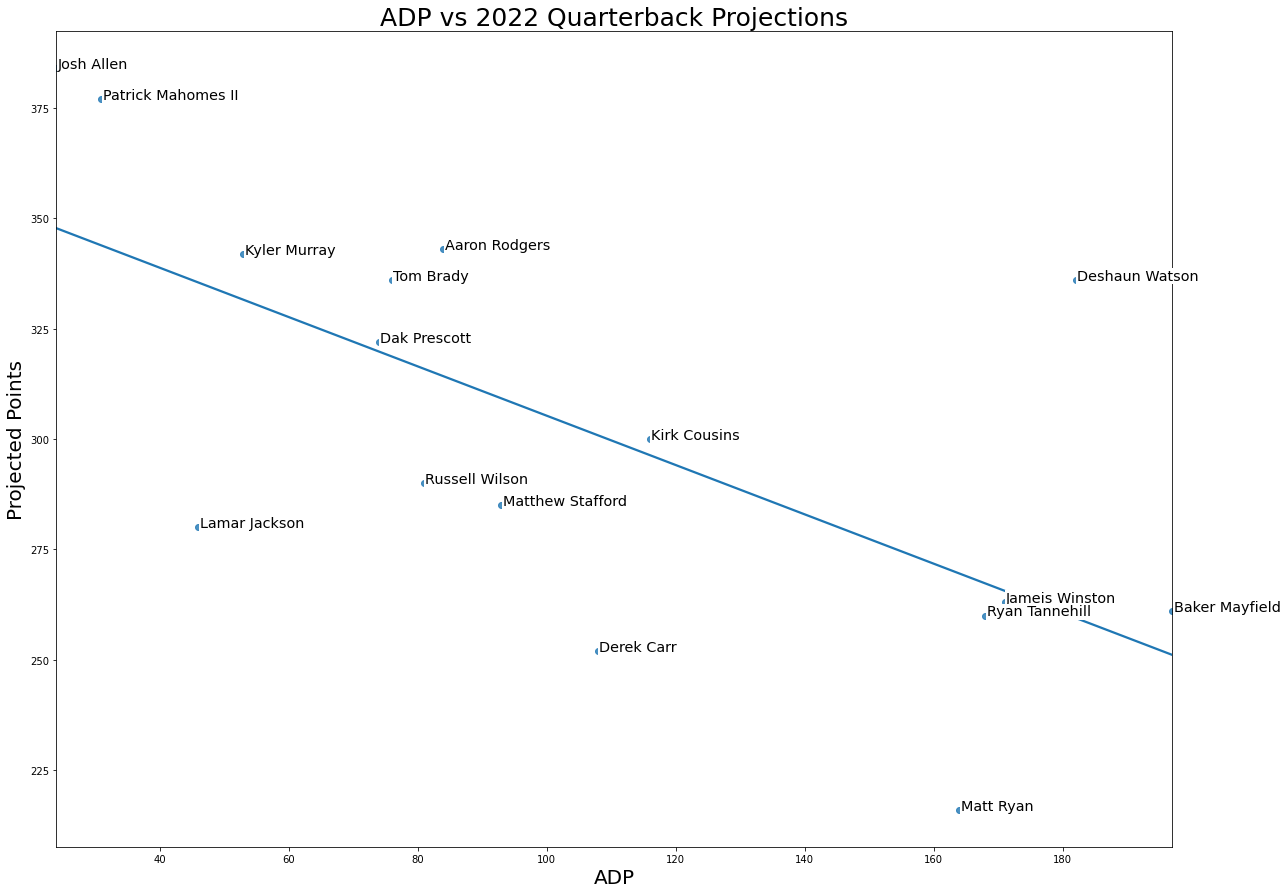

In [452]:
adp_plot(qb_adp_df, 'Quarterback');

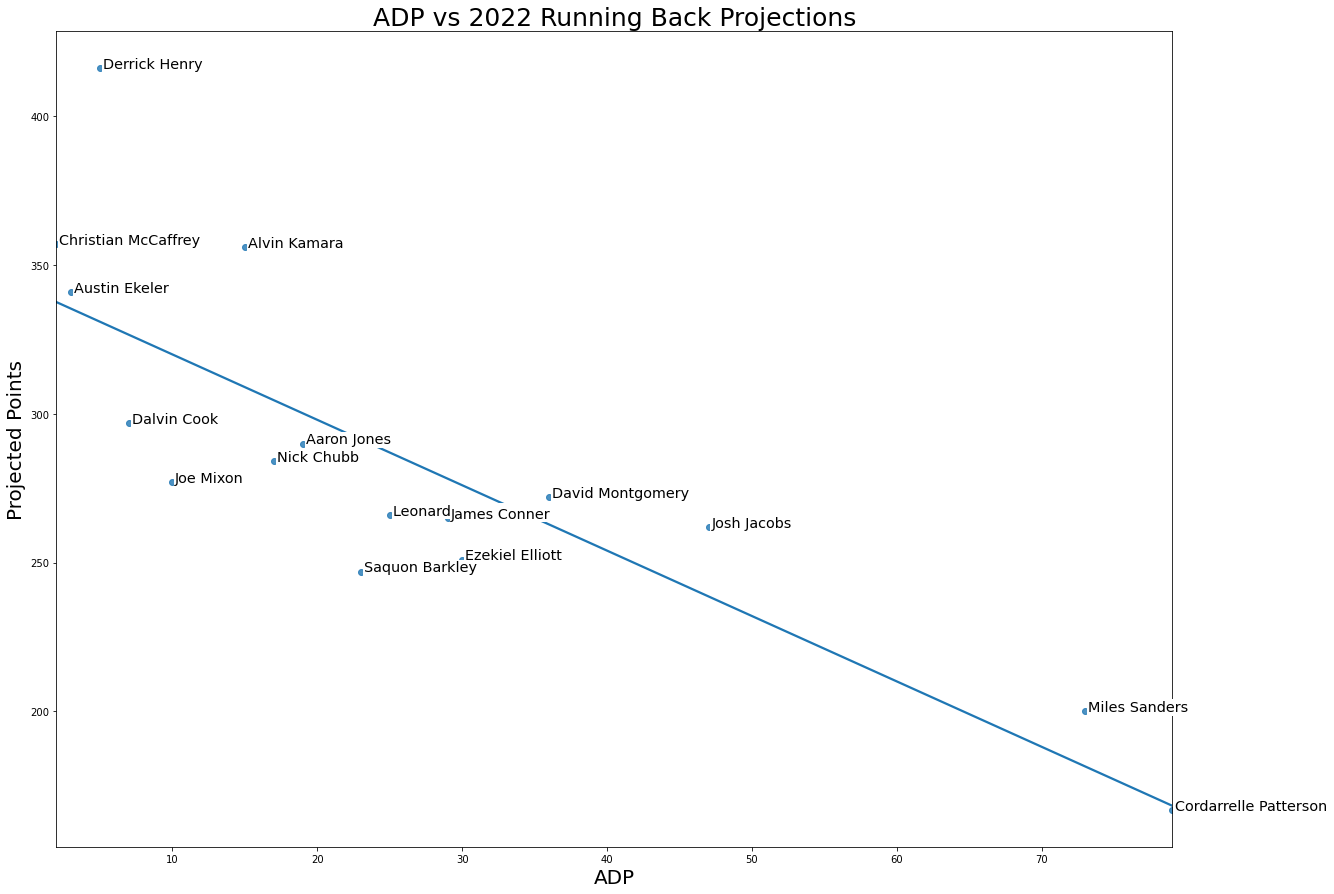

In [453]:
adp_plot(rb_adp_df_100, 'Running Back');

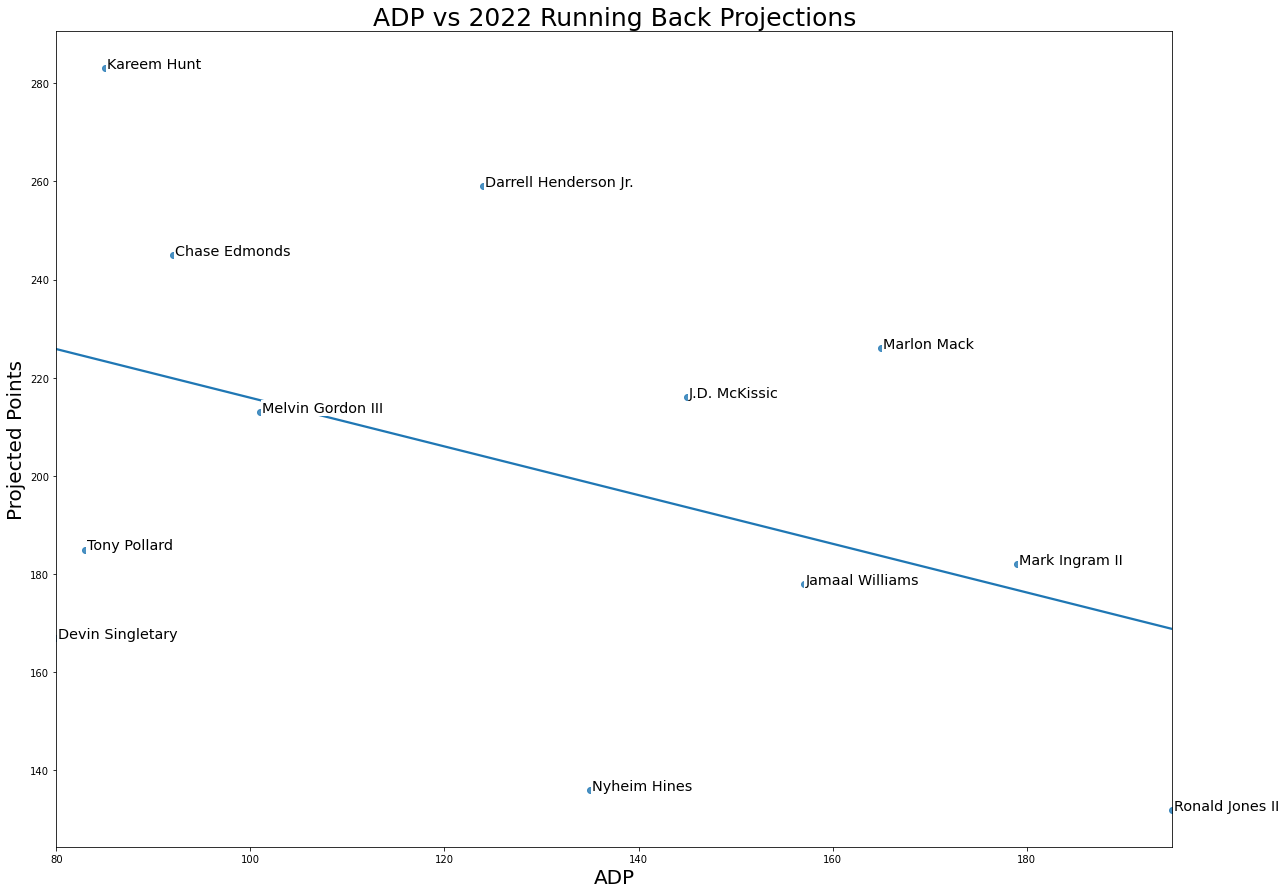

In [454]:
adp_plot(rb_adp_df_200, 'Running Back');

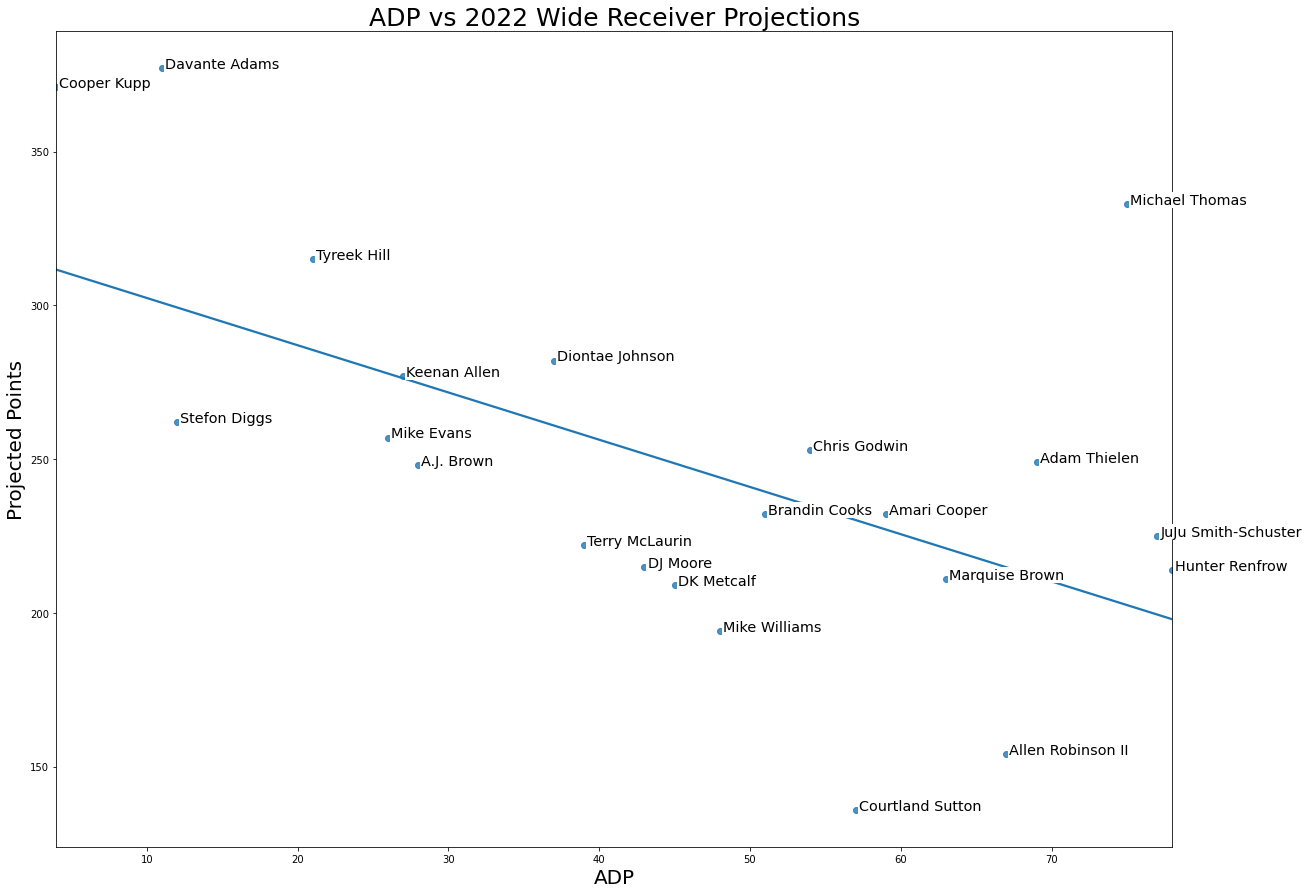

In [455]:
adp_plot(wr_adp_df_100, 'Wide Receiver');

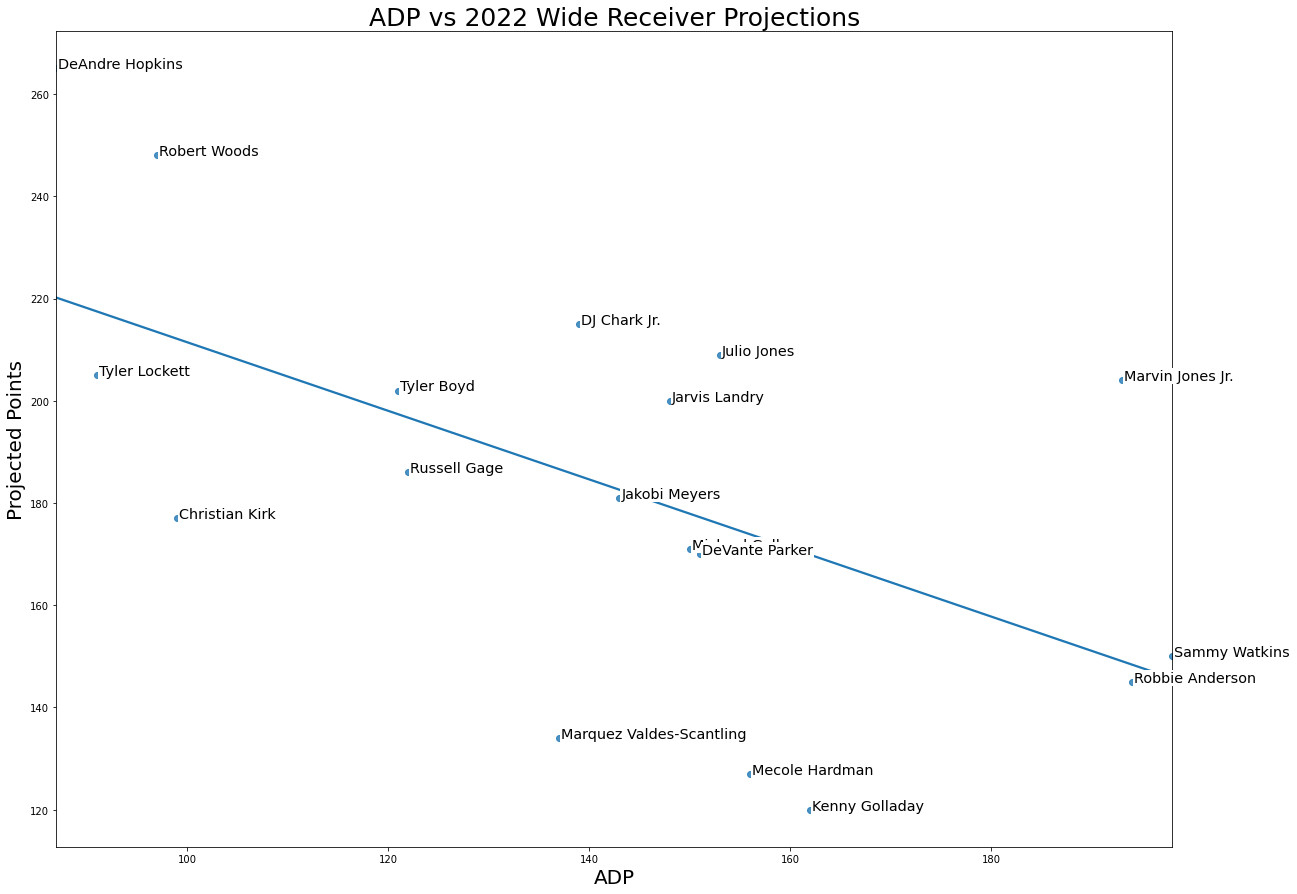

In [456]:
adp_plot(wr_adp_df_200, 'Wide Receiver');

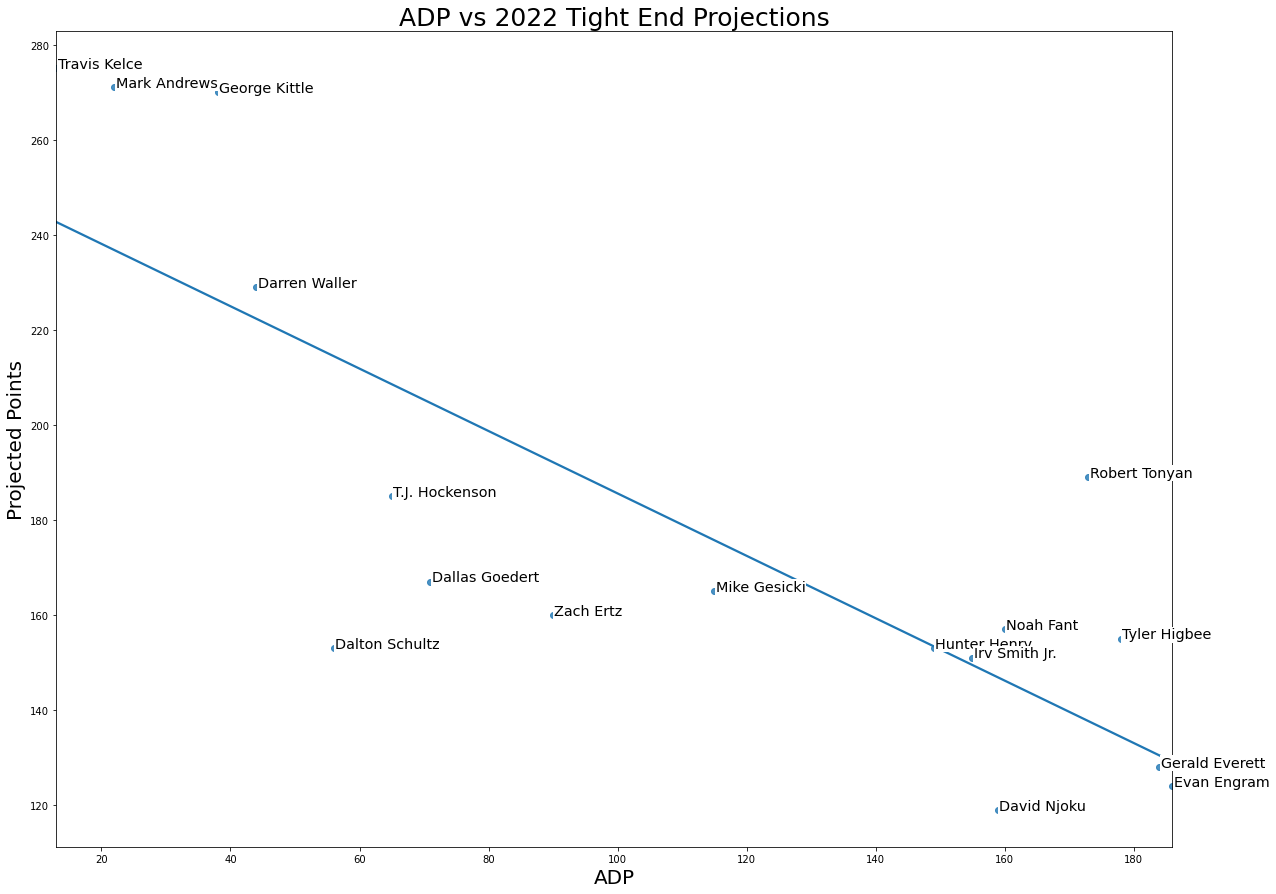

In [457]:
adp_plot(te_adp_df, 'Tight End');

## Recommendations

## Future Work